## 1. 고객 정보

In [92]:
# --- 파일 경로 정의 ---
# 각 엑셀 파일의 실제 위치에 맞게 경로를 수정해주세요.
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
# 'r설문지 응답' 시트가 포함된 원본 엑셀 파일의 경로를 지정해야 합니다.
# (업로드된 파일 목록에서는 이 파일의 원본 .xlsx가 아닌 CSV만 확인되므로,
# 실제 실행 환경에 원본 파일이 있다고 가정하고 경로를 작성했습니다.)
retirement_model_file_path = '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx'

try:
    # --- 데이터 추출 ---

    # 1. 가계부 엑셀 파일에서 정보 가져오기
    # 파일: 손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm
    # 시트: 뱅샐현황
    df_household = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    # iloc[row, column]를 사용하여 특정 셀 값 추출 (0부터 시작)
    age = df_household.iloc[5, 3]      # D6 셀
    gender = df_household.iloc[5, 2]   # C6 셀
    credit_score = df_household.iloc[5, 4] # E6 셀


    # 2. 은퇴설계 모델 엑셀 파일에서 직업 정보 가져오기
    # 파일: 손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx
    # 시트: r설문지 응답
    # 엑셀의 특정 시트를 직접 읽도록 수정했습니다.
    df_retirement_survey = pd.read_excel(retirement_model_file_path, sheet_name='r설문지 응답', header=None)

    # C12 셀에 해당하는 데이터 추출
    job = df_retirement_survey.iloc[11, 3] # C열(2), 12번째 행(11)


    # --- client_profile 딕셔너리 생성 ---
    
    client_profile = {
        "고객정보": {
            "고객명": "넉넉한 윤리쌤",
            "나이": age,
            "직업": job,
            "성별": gender,
            "신용점수": credit_score
        }
    }

    # --- 결과 확인 ---
    print("✅ '고객정보' 생성이 완료되었습니다. (수정 완료)")
    
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError as e:
    # 사용자가 원본 .xlsx 파일을 업로드하지 않았을 경우를 대비한 안내
    print(f"오류: 파일을 찾을 수 없습니다.")
    print(f"지정한 경로에 '{e.filename}' 파일이 있는지 확인해주세요.")
    print("특히 '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx' 파일이 필요합니다.")
    
except ValueError as e:
    # 엑셀에 해당 시트가 없을 경우 발생하는 오류 처리
    if "Worksheet" in str(e) and "not found" in str(e):
        print(f"오류: 엑셀 파일 안에 '{retirement_model_file_path}' 시트가 없습니다. 시트 이름을 확인해주세요.")
    else:
        print(f"데이터를 읽는 중 오류가 발생했습니다: {e}")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---
# 만약 이 스크립트를 단독으로 실행한다면, 아래 주석을 해제하여 client_profile을 생성해주세요.
# client_profile = {"고객정보": {}}


# --- 파일 경로 정의 ---
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'

try:
    # --- 데이터 불러오기 및 전처리 ---
    df = pd.read_excel(household_file_path, sheet_name='가계부 내역', engine='openpyxl')
    
    # '거래일' 컬럼을 날짜 형식으로 변환 (오류 발생 시 무시)
    df['거래일'] = pd.to_datetime(df['거래일'], errors='coerce')
    # 날짜 형식이 아닌 데이터 제거
    df.dropna(subset=['거래일'], inplace=True)

    # --- 분석 기준월('이번 달') 결정 ---
    latest_date = df['거래일'].max()
    # is_month_end는 해당 월의 마지막 날인지 확인하는 pandas 기능입니다.
    if latest_date.is_month_end:
        analysis_month_period = pd.Period(latest_date, freq='M')
    else:
        # 월말이 아니면, 한 달을 뺀다.
        analysis_month_period = pd.Period(latest_date, freq='M') - 1
    
    print(f"알림: 데이터의 최근 날짜는 {latest_date.strftime('%Y-%m-%d')} 입니다.")
    print(f"알림: 분석 기준월('이번 달')은 '{analysis_month_period.strftime('%Y년 %m월')}' 입니다.")

    # --- 최근 3개월간 월별 데이터 계산 ---
    monthly_summary = []
    for i in range(3):
        target_month = analysis_month_period - i
        
        # 해당 월의 데이터 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month]

        # 1. 수입 계산
        income = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        
        # 2. 지출 계산 (지출 - 이체)
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        expenditure = spend_total + transfer_total
        
        # 3. 저축/투자 계산
        investment = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # 4. 현금(여윳돈)
        cash_surplus = income - (expenditure + investment) + investment

        monthly_summary.append({
            "month": target_month,
            "income": income,
            "expenditure": expenditure,
            "investment": investment,
            "cash_surplus" : cash_surplus
        })

    # --- 최종 지표 계산 ---
    # 1) ~ 4) '이번 달' 현황
    this_month_data = monthly_summary[0]
    this_month_income = this_month_data['income']
    this_month_expenditure = this_month_data['expenditure']
    this_month_investment = this_month_data['investment']


    # 현금(여윳돈) = 수입 - (지출 + 저축/투자)
    this_month_cash_surplus = this_month_income - (this_month_expenditure + this_month_investment) + this_month_investment

    # 5) ~ 8) 3개월 평균 현황
    avg_income = sum(item['income'] for item in monthly_summary) / 3
    avg_expenditure = sum(item['expenditure'] for item in monthly_summary) / 3
    avg_investment = sum(item['investment'] for item in monthly_summary) / 3
    avg_cash_surplus = sum(item['cash_surplus'] for item in monthly_summary) / 3

    # 평균 순수입 = 평균 수입 - 평균 지출
    avg_net_income = avg_income - avg_expenditure

    # --- client_profile 딕셔너리에 추가 ---
    client_profile['수입/지출/투자 현황'] = {
        "분석 기준월": analysis_month_period.strftime('%Y-%m'),
        "이번 달 수입": f"{this_month_income:,.0f}원",
        "이번 달 지출": f"{this_month_expenditure:,.0f}원",
        "이번 달 저축/투자": f"{this_month_investment:,.0f}원",
        "이번 달 현금(여윳돈)": f"{this_month_cash_surplus:,.0f}원",
        "최근 3개월 평균 수입": f"{avg_income:,.0f}원",
        "최근 3개월 평균 지출": f"{avg_expenditure:,.0f}원",
        "최근 3개월 평균 순수입": f"{avg_net_income:,.0f}원",
        "최근 3개월 평균 저축/투자": f"{avg_investment:,.0f}원",
        "최근 3개월 평균 현금(여윳돈)" : f"{avg_cash_surplus:,.0f}원"
    }

    # --- 결과 확인 ---
    print("\n✅ '수입/지출/투자 현황' 생성이 완료되었습니다.")
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError:
    print(f"오류: '{household_file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile, df, analysis_month_period 변수가 생성되어 있다고 가정합니다. ---

try:
    # --- 최종 데이터를 담을 딕셔너리 초기화 ---
    monthly_cash_flow_final = {}

    # --- 최근 6개월간 월별로 데이터 처리 ---
    for i in range(6):
        # 역순으로 6개월간의 월을 하나씩 가져옴 (예: 5월 -> 4월 -> 3월...)
        target_month_period = analysis_month_period - i
        month_str = target_month_period.strftime('%Y-%m')
        
        # 해당 월의 데이터만 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month_period]

        # --- 1. 대분류별 총합 계산 ---
        income_total = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        investment_total = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # --- 2. 중분류 상세 내역 계산 ---
        income_details = df_month[df_month['pv_대분류'] == '수입'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        spend_details = df_month[df_month['pv_대분류'].isin(['지출', '이체'])].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        investment_details = df_month[df_month['pv_대분류'] == '저축/투자'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()

        # --- 3. 해당 월의 최종 데이터 구조 조립 ---
        month_data = {
            "수입": {
                "총합": income_total,
                "상세내역": {k: v for k, v in sorted(income_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "총지출(이체포함)": {
                "총합": spend_total + transfer_total,
                "상세내역": {k: v for k, v in sorted(spend_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "저축/투자": {
                "총합": investment_total,
                "상세내역": {k: v for k, v in sorted(investment_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "순현금흐름(여윳돈)": income_total - (spend_total + transfer_total + investment_total) + investment_total
        }
        
        # --- 4. [특별 처리] '이번 달'에만 '소분류' 데이터 추가 ---
        if target_month_period == analysis_month_period:
            # '총지출(이체포함)'의 중분류 항목들에 대해 소분류 내역 추가
            spend_details_with_small = {}
            for mid_category, mid_total in month_data["총지출(이체포함)"]["상세내역"].items():
                small_category_details = df_month[df_month['pv_중분류'] == mid_category] \
                                         .groupby('pv_소분류')['pv_지출액'].sum().to_dict()
                
                spend_details_with_small[mid_category] = {
                    "총합": mid_total,
                    "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                }
            # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
            month_data["총지출(이체포함)"]["상세내역"] = spend_details_with_small
        
            # [수정된 부분] '저축/투자'의 중분류 항목들에 대해 소분류 내역 추가
            investment_details_with_small = {}
            if month_data["저축/투자"]["상세내역"]:
                for mid_category, mid_total in month_data["저축/투자"]["상세내역"].items():
                    small_category_details = df_month[
                        (df_month['pv_대분류'] == '저축/투자') &
                        (df_month['pv_중분류'] == mid_category)
                    ].groupby('pv_소분류')['pv_지출액'].sum().to_dict()

                    investment_details_with_small[mid_category] = {
                        "총합": mid_total,
                        "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                    }
                # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
                month_data["저축/투자"]["상세내역"] = investment_details_with_small
        
        # 최종 딕셔너리에 해당 월의 데이터를 추가
        monthly_cash_flow_final[month_str] = month_data


    # --- client_profile 딕셔너리에 추가 ---
    # 월별로 정렬하여 최종 저장
    client_profile['월별 현금흐름 요약'] = dict(sorted(monthly_cash_flow_final.items()))

    # --- 결과 확인 ---
    print("\n✅ '월별 현금흐름 요약 (최종 수정 버전)' 생성이 완료되었습니다.")
    
    import json
    # 전체 6개월 데이터가 모두 포함된 것을 확인
    print(json.dumps(client_profile['월별 현금흐름 요약'], ensure_ascii=False, indent=4, default=str))

except NameError as e:
    print(f"오류: 이전 단계의 변수({e})가 필요합니다. 이전 코드들을 먼저 실행해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd
import numpy as np

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---

try:
    # --- 1. 데이터 불러오기 및 동적 범위 탐색 ---
    household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
    df = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    col_b = df.iloc[:, 1].astype(str)
    start_row_series = col_b[col_b.str.contains("자유입출금 자산", na=False)]
    end_row_series = col_b[col_b.str.contains("연금 자산", na=False)]

    if start_row_series.empty or end_row_series.empty:
        raise ValueError("자산/부채 테이블의 시작('자유입출금 자산') 또는 끝('연금 자산') 위치를 찾을 수 없어 중단합니다.")
    
    start_row = start_row_series.index[0]
    end_row = end_row_series.index[0]

    # --- 2. 데이터 테이블 슬라이싱 및 전처리 ---
    df_table = df.iloc[start_row:end_row + 1].copy()
    df_table.iloc[:, 1] = df_table.iloc[:, 1].ffill() # 자산 중분류 병합 처리
    df_table.iloc[:, 5] = df_table.iloc[:, 5].ffill() # 부채 중분류 병합 처리

    # --- 3. 자산/부채 상세 데이터 구조화 ---
    assets_dict = {}
    liability_dict = {}

    # 자산 처리 (B, C, E 열)
    asset_data = df_table[[1, 2, 4]].dropna(subset=[2])
    for index, row in asset_data.iterrows():
        mid_category, product_name, amount_raw = row[1], row[2], row[4]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            assets_dict.setdefault(mid_category, {})[product_name] = amount

    # 부채 처리 (F, G, I 열)
    liability_data = df_table[[5, 6, 8]].dropna(subset=[6])
    for index, row in liability_data.iterrows():
        mid_category, product_name, amount_raw = row[5], row[6], row[8]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            liability_dict.setdefault(mid_category, {})[product_name] = amount

    # --- 4. [핵심 수정] 상세 내역을 합산하여 총계 계산 ---
    # 각 중분류 딕셔너리의 모든 금액(value)들을 합산
    total_assets_val = sum(sum(v.values()) for v in assets_dict.values())
    total_liability_val = sum(sum(v.values()) for v in liability_dict.values())
    net_assets_val = total_assets_val - total_liability_val

    # --- 5. client_profile에 최종 데이터 추가 ---
    client_profile['자산/부채 현황'] = {
        "총자산": total_assets_val,
        "총부채": total_liability_val,
        "순자산": net_assets_val,
        "자산 상세": assets_dict,
        "부채 상세": liability_dict
    }
    
    # --- 결과 확인 ---
    print("\n✅ '자산/부채 현황' 생성이 완료되었습니다. (총계 계산 로직 수정)")
    
    import json
    print(json.dumps(client_profile['자산/부채 현황'], ensure_ascii=False, indent=4, default=str))

except ValueError as e:
    print(f"오류: {e}")
except Exception as e:
    print(f"데이터 처리 중 예상치 못한 오류가 발생했습니다. 엑셀 파일의 구조나 내용을 확인해주세요.")
    print(f"오류 상세: {e}")


def extract_survey_answers(df):
    answers = {}
    for _, row in df.iterrows():
        question = str(row[2]).strip()
        response = str(row[3]).strip()
        if question and response and response.lower() != "nan":
            answers[question] = response
    return answers

# --- 메인 실행 함수 ---
def generate_client_inputs(retirement_path, budget_path):
    df_core = pd.read_excel(retirement_path, sheet_name="핵심 정보(가정,변수)", header=None)
    age = int(df_core.iloc[4, 2])
    retire_age = int(df_core.iloc[5, 2])
    years_to_retire = retire_age - age
    
    df_banksalad_status = pd.read_excel(budget_path, sheet_name="뱅샐현황", header=None)
    df_banksalad_status = df_banksalad_status.dropna(how='all', axis=0).dropna(how='all', axis=1)
    df_banksalad_status = df_banksalad_status.fillna('')

    df_survey_raw = pd.read_excel(retirement_path, sheet_name="r설문지 응답", header=None)
    survey = extract_survey_answers(df_survey_raw)

    profile = {
        "age": age,
        "retirement_age_target": retire_age,
        "years_to_retire": years_to_retire,
        
    }

    return profile, survey

# --- 실행 ---
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"
budget_file = "손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm"
survey_answers = generate_client_inputs(retirement_file, budget_file)

# --- 결과 확인 ---
print("✅ 최종 고객 프로필 (구조화된 데이터):")
client_profile

print("\n\n✅ 설문조사 응답:")
print(json.dumps(survey_answers, indent=2, ensure_ascii=False))

✅ '고객정보' 생성이 완료되었습니다. (수정 완료)
{
    "고객정보": {
        "고객명": "넉넉한 윤리쌤",
        "나이": 30,
        "직업": "공무원",
        "성별": "남",
        "신용점수": 934
    }
}
알림: 데이터의 최근 날짜는 2025-06-07 입니다.
알림: 분석 기준월('이번 달')은 '2025년 05월' 입니다.

✅ '수입/지출/투자 현황' 생성이 완료되었습니다.
{
    "고객정보": {
        "고객명": "넉넉한 윤리쌤",
        "나이": 30,
        "직업": "공무원",
        "성별": "남",
        "신용점수": 934
    },
    "수입/지출/투자 현황": {
        "분석 기준월": "2025-05",
        "이번 달 수입": "2,737,394원",
        "이번 달 지출": "2,429,616원",
        "이번 달 저축/투자": "800,000원",
        "이번 달 현금(여윳돈)": "307,778원",
        "최근 3개월 평균 수입": "4,751,009원",
        "최근 3개월 평균 지출": "3,138,115원",
        "최근 3개월 평균 순수입": "1,612,893원",
        "최근 3개월 평균 저축/투자": "800,000원",
        "최근 3개월 평균 현금(여윳돈)": "1,612,893원"
    }
}

✅ '월별 현금흐름 요약 (최종 수정 버전)' 생성이 완료되었습니다.
{
    "2024-12": {
        "수입": {
            "총합": "3360461",
            "상세내역": {
                "기타수입": 3357220,
                "금융수입": 2468,
                "앱테크": 429,
         

## 2. 포트폴리오 추천 자산군 정리

In [93]:
# 표준 라이브러리
import os, re, json, math
from datetime import datetime  # 날짜/시간 처리
import warnings
from copy import deepcopy

# 수치/데이터/시각화
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter

# 최적화
try:
    import cvxpy as cp  # 포트폴리오/제약 최적화
except Exception as e:
    # 필수 패키지 미설치 시 즉시 명확한 에러를 던짐
    raise ImportError("cvxpy가 필요합니다. pip install cvxpy 후 재시도") from e

# 재무 데이터
import yfinance as yf  # 야후파이낸스 (시계열 다운로드)

# 스크립트/노트북 기준 경로
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

def resolve_path(filename: str) -> str:
    p = os.path.join(BASE_DIR, filename)
    if not os.path.exists(p):
        print(f"[경고] 파일을 찾을 수 없습니다: {p}")
    return p


# =============================================================================
# 데이터 파일 상수 (프로젝트에서 반복 참조하는 자산군/은퇴모델 파일)
# =============================================================================

BOND_XLSX   = resolve_path("자산군-국내채권.xlsx")           # 국내 채권 관련 데이터
STOCK_XLSX  = resolve_path("자산군-주식지수.xlsx")           # 주식 지수 관련 데이터
RETIRE_XLSX = resolve_path("손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx")  # 은퇴설계 모델 파일


### 2-1. 주식/채권 자산군

In [94]:

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' for Mac, 'NanumGothic' if 설치됨
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 기준 시작일
start_date = pd.to_datetime("2003-03-31")

# 원본 엑셀 불러오기
df_bond = pd.read_excel(BOND_XLSX, sheet_name="Sheet1")
df_stock = pd.read_excel(STOCK_XLSX, sheet_name="Sheet1")

# === 채권 데이터 클렌징 함수 === 
def clean_bond_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name == "KRX 채권지수 국채 10Y~":  # NaN 열 및 제외 대상 필터링
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# === 주식 데이터 클렌징 함수 === 
def clean_stock_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name in ["코스닥150", "KRX 금현물지수"]:
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# 클렌징된 데이터 생성
df_bond_cleaned = clean_bond_data(df_bond)
df_stock_cleaned = clean_stock_data(df_stock)

# === GLD 데이터 다운로드 및 병합 === 
gold_df = yf.download("GLD", start="2003-03-31", interval="1mo")

if "Close" in gold_df.columns:
    gold = gold_df["Close"].copy()
    gold.name = "Gold ETF (GLD)"
    gold.index = gold.index.to_period("M").to_timestamp("M")
    gold = gold[~gold.index.duplicated(keep="last")]
    df_stock_cleaned = pd.concat([df_stock_cleaned, gold], axis=1)

# === 병합 (공통 일자 기준) === #
common_index = df_stock_cleaned.index.intersection(df_bond_cleaned.index)
df_merged = df_stock_cleaned.loc[common_index].join(df_bond_cleaned.loc[common_index])

# 결과 확인
df_merged.head()

C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\3086921766.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\3086921766.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\3086921766.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\3086921766.py:24:

,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2006-04-30,1419.73,184.1,685.44,1310.61,1700.71,1172.35,16906.23,3839.9,65.089996,100.630751,100.975868,101.123958,101.077159,101.144828
2006-05-31,1317.7,171.01,630.5,1270.09,1579.58,1365.45,15467.33,3637.17,64.230003,101.048529,101.582403,101.909835,102.073692,101.748919
2006-06-30,1295.15,167.45,590.68,1270.2,1575.23,1393.96,15505.18,3648.92,61.230000,101.260219,101.557437,101.750776,102.128971,101.817169
2006-07-31,1297.82,168.51,557.66,1276.66,1509.43,1294.33,15456.81,3691.87,63.160000,101.487199,102.160262,102.543039,103.662726,102.455204
2006-08-31,1352.74,175.44,572.83,1303.82,1579.73,1338.46,16140.76,3808.7,62.290001,101.930072,102.710402,103.293889,104.680725,103.058649


In [95]:
import pandas as pd

# 최근 10년 기준일 계산
end_date = df_merged.index.max()
start_date_10yr = end_date - pd.DateOffset(years=10)

# 최근 10년치 필터링
df_recent_10yr = df_merged[df_merged.index >= start_date_10yr].copy()

# 수익률 계산 (월별 기준)
df_returns = df_recent_10yr.pct_change().dropna()

# 결과 확인
df_returns.tail()


C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\1238498582.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_recent_10yr.pct_change().dropna()


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2025-03-31,-0.020397,-0.005594,-0.095583,-0.057545,-0.076898,-0.000704,-0.041392,-0.039379,0.094466,0.002315,0.002291,0.002220,-0.000488,0.002335
2025-04-30,0.030426,0.019073,0.065973,-0.007625,0.015176,-0.030031,0.012011,-0.016799,0.054244,0.003333,0.009310,0.012996,0.017598,0.008288
2025-05-31,0.055175,0.061640,0.023855,0.061524,0.090438,0.018475,0.053258,0.039992,-0.000560,0.002643,0.000839,-0.001326,-0.008993,0.001080
2025-06-30,0.138649,0.152884,0.064206,0.049607,0.062697,0.024959,0.066437,-0.011805,0.004051,0.001537,-0.000570,-0.000589,-0.000160,0.001196
2025-07-31,0.040482,0.039026,0.032566,0.029604,0.026158,0.048546,0.023929,0.009225,-0.006135,0.001347,0.002121,0.001838,0.000728,0.002237


In [96]:

# =======================================
# ① 월별 수익률
# =======================================
df_monthly_return = df_recent_10yr.pct_change().dropna()

# =======================================
# ② 연간 수익률
# =======================================
# 연말 기준으로 리샘플링하여 연간 수익률 계산: (연말 / 전연말) - 1
df_annual_price = df_recent_10yr.resample('Y').last()
df_annual_return = df_annual_price.pct_change().dropna()

# 연도 인덱스 포맷 정리
df_annual_return.index = df_annual_return.index.year

# =======================================
# ③ 누적 수익률
# =======================================
df_cum_return = (1 + df_monthly_return).cumprod() - 1  # 누적 수익률

# =======================================
# 결과 확인
# =======================================

print("\n✅ 누적 수익률")
df_cum_return



✅ 누적 수익률


C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\2259159998.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_monthly_return = df_recent_10yr.pct_change().dropna()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\2259159998.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual_price = df_recent_10yr.resample('Y').last()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_28556\2259159998.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_annual_return = df_annual_price.pct_change().dropn

,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2015-08-31,-0.043676,-0.047073,-0.052340,-0.062581,-0.068496,-0.117946,-0.082329,-0.091943,0.037072,0.001216,0.002139,0.004572,0.010491,0.003634
2015-09-30,-0.033175,-0.031068,-0.064243,-0.087369,-0.088877,-0.160807,-0.155310,-0.138868,0.018393,0.002886,0.007650,0.014802,0.028725,0.008459
2015-10-31,-0.000340,0.020917,-0.057140,-0.011636,0.013058,-0.074048,-0.072972,-0.050674,0.041647,0.003936,0.006764,0.013322,0.026691,0.008314
2015-11-30,-0.018811,-0.000246,-0.050589,-0.011137,0.016475,-0.065577,-0.040698,-0.026173,-0.028686,0.004411,0.004824,0.008448,0.018418,0.004717
2015-12-31,-0.033914,-0.016046,-0.058905,-0.028472,0.000951,-0.022454,-0.075371,-0.092529,-0.033070,0.006412,0.009579,0.015716,0.030306,0.010382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,0.222130,0.360622,-0.072008,1.667432,3.201098,0.018501,0.730247,0.457607,1.746021,0.199540,0.217747,0.234581,0.228298,0.277128
2025-04-30,0.259315,0.386574,-0.010785,1.647093,3.264854,-0.012086,0.751030,0.433120,1.894977,0.203539,0.229084,0.250625,0.249913,0.287714
2025-05-31,0.328797,0.472043,0.012813,1.809952,3.650561,0.006165,0.844287,0.490434,1.893358,0.206720,0.230116,0.248967,0.238673,0.289104
2025-06-30,0.513033,0.697094,0.077842,1.949345,3.942138,0.031279,0.966817,0.472840,1.905079,0.208575,0.229415,0.248232,0.238474,0.290646


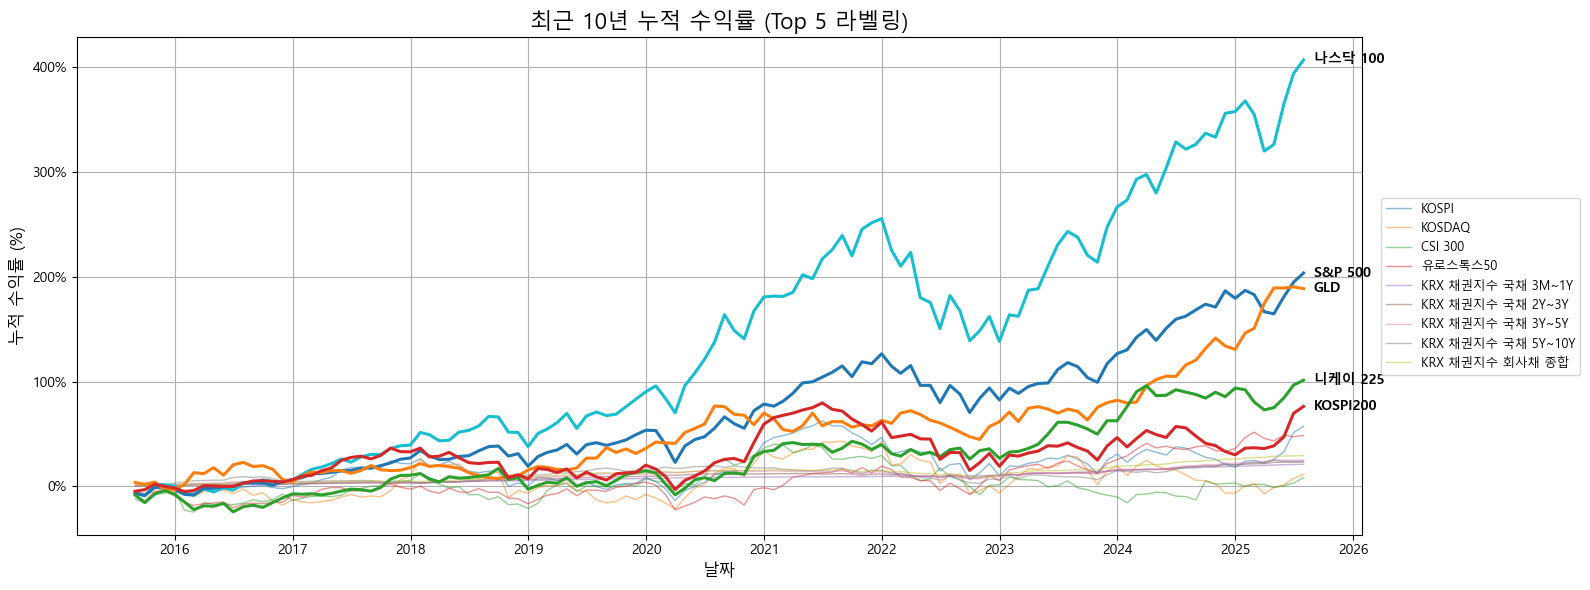

In [97]:
plt.figure(figsize=(16, 6))   # 가로=16, 세로=6 인치

# 마지막 시점 기준 누적 수익률 상위 5개 자산
last_returns = df_cum_return.iloc[-1]
top_assets = last_returns.sort_values(ascending=False).head(5).index
other_assets = [col for col in df_cum_return.columns if col not in top_assets]

# 나머지 자산들 (범례 사용)
for column in other_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], label=column, linewidth=1, alpha=0.5)

# 상위 5개 자산 (직접 라벨링)
for column in top_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], linewidth=2.2)
    last_date = df_cum_return.index[-1]
    last_value = df_cum_return[column].iloc[-1]
    plt.text(last_date + pd.DateOffset(months=1),
             last_value,
             column,
             fontsize=10,
             va='center',
             fontweight='bold')




# y축 퍼센트 형식
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# 그래프 설정
plt.title("최근 10년 누적 수익률 (Top 5 라벨링)", fontsize=16)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("누적 수익률 (%)", fontsize=12)
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), fontsize=9)  # 범례는 나머지용
plt.tight_layout()

plt.show()

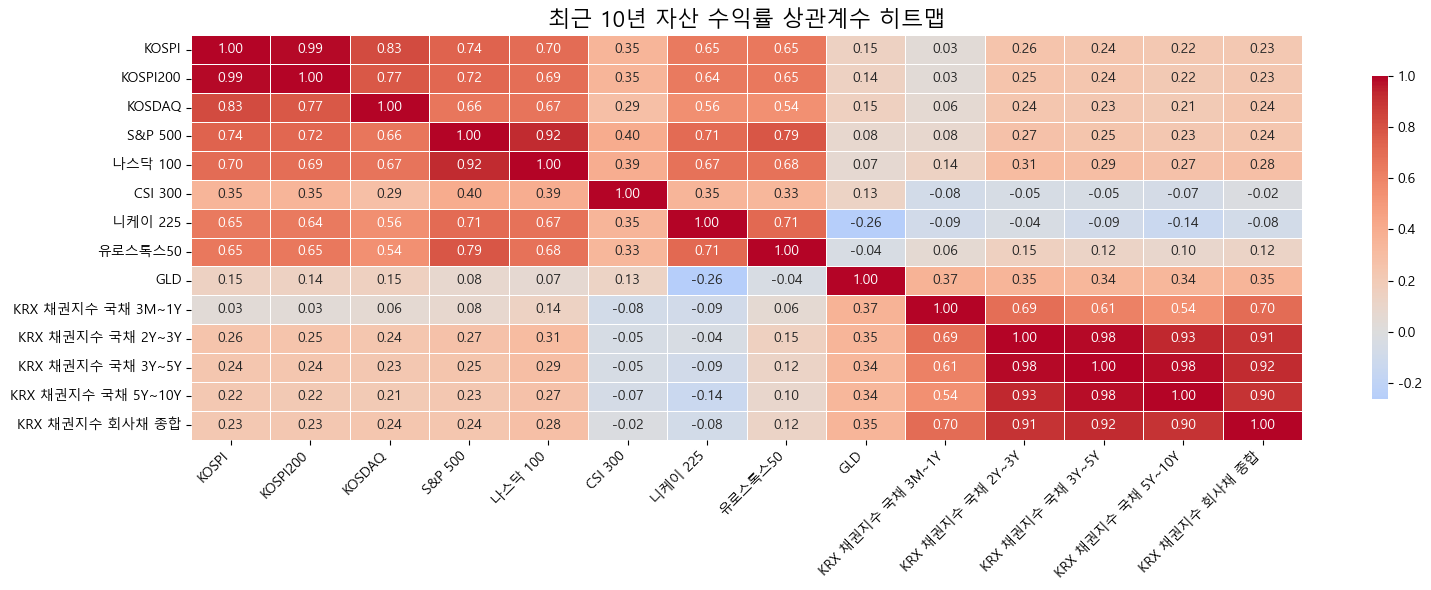

In [98]:
import seaborn as sns

# ① 공분산 행렬
cov_matrix = df_monthly_return.cov()

# ② 상관계수 행렬
corr_matrix = df_monthly_return.corr()

# 히트맵 시각화
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("최근 10년 자산 수익률 상관계수 히트맵", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 2-2. 예/적금/청약통장 자산군

1. 예/적금 상품
- 가장 이율 높은 상품 한 개 추천

2. 청년도약계좌 및 청약통장(청년 주택드림 등)은 필수로 가입하는 게 권장되니, 일단 의무로 포트폴리오에 편입

3. 청년도약계좌
- 연봉별로 가장 먼저 지원금이 다름
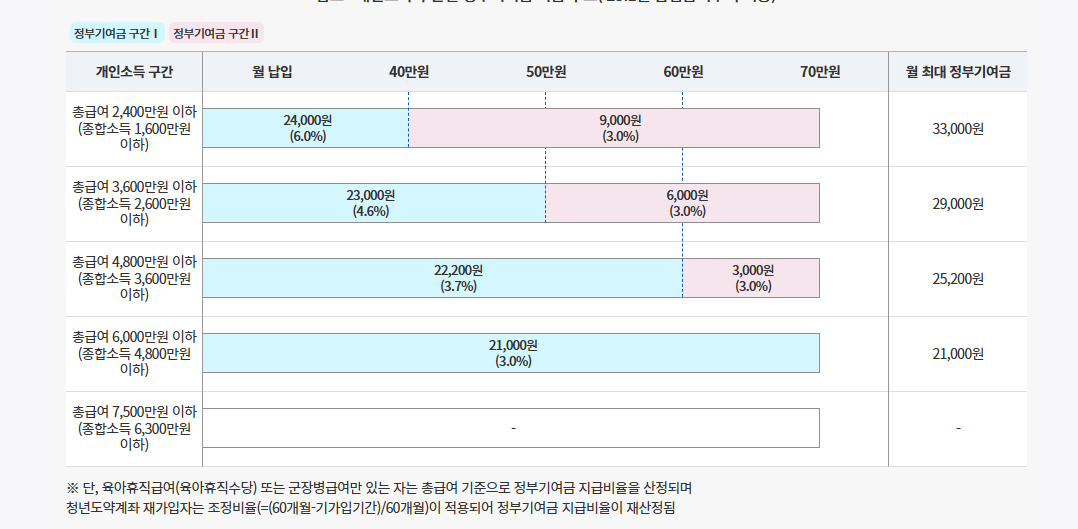
4. 청약통장
- 그냥 월별 10만원



#### 2-2-1. 청년도약계좌

In [99]:
import pandas as pd
import numpy as np
from typing import Dict, Tuple

# 청년도약계좌 상품 정보를 상수로 정의 (이미지 및 기존 코드 기반)
# 소득구간(상한선, 만원 단위)을 Key로 사용하여 데이터를 구조화
YLA_BANDS_INFO = {
    2400: {"max_contribution": 24000, "rate_at_400k": 0.060}, # 총급여 ~2,400만원
    3600: {"max_contribution": 23000, "rate_at_400k": 0.046}, # 총급여 ~3,600만원
    4800: {"max_contribution": 22000, "rate_at_400k": 0.037}, # 총급여 ~4,800만원
    6000: {"max_contribution": 21000, "rate_at_400k": 0.030}, # 총급여 ~6,000만원
    7500: {"max_contribution": 0, "rate_at_400k": 0.0},       # 총급여 ~7,500만원 (기여금 없음)
}
# 60만원 납입 시 공통 적용되는 기여율
YLA_CAP_RATE_AT_600K = 0.030

class YouthLeapAccount:
    """
    청년도약계좌의 소득구간 및 월납입액에 따른
    정부기여금 및 총기대수익률을 계산하고 테이블을 생성하는 클래스입니다.
    """
    def __init__(self, household_file_path: str):
        """
        클래스 초기화 시 가계부 파일 경로를 받아 연소득과 소득구간을 자동으로 탐지합니다.
        """
        self.household_file_path = household_file_path
        self.annual_salary = self._get_annual_salary()
        self.income_band_key = self._get_income_band_key()
        print(f"✅ 고객님의 추정 연소득: {self.annual_salary:,.0f}원")
        print(f"✅ 적용 소득구간: 총급여 {self.income_band_key:,}만원 이하")

    def _get_annual_salary(self) -> float:
        """가계부 파일('뱅샐현황' 시트)에서 연소득을 추정합니다."""
        try:
            df = pd.read_excel(
                self.household_file_path,
                sheet_name='뱅샐현황',
                usecols="E:J", # E~J 열 (월급 데이터)
                engine='openpyxl'
            )
            # 엑셀 19행(pandas 18번 인덱스) 데이터의 평균을 월급으로 간주
            monthly_salary = df.iloc[17].mean()
            return monthly_salary * 12
        except Exception as e:
            print(f"⚠️ 가계부 파일에서 소득 정보를 읽는 중 오류 발생: {e}")
            return 0.0

    def _get_income_band_key(self) -> int:
        """연소득을 기준으로 소득구간 키(상한선, 만원 단위)를 반환합니다."""
        salary_in_won = self.annual_salary / 10000
        for band_max in sorted(YLA_BANDS_INFO.keys()):
            if salary_in_won <= band_max:
                return band_max
        return max(YLA_BANDS_INFO.keys()) # 범위를 초과하면 가장 높은 구간으로 처리

# (YouthLeapAccount 클래스 내의 이 함수만 아래 코드로 교체하시면 됩니다)

    def calculate_contribution(self, monthly_deposit: int) -> int:
        """
        월납입액(40/50/60/70)에 따른 정부기여금을 직접 계산합니다.
        """
        band_info = YLA_BANDS_INFO.get(self.income_band_key)
        if not band_info or monthly_deposit <= 0:
            return 0

        max_contribution = band_info["max_contribution"]
        
        # 각 납입액 케이스별로 기여금을 명시적으로 계산
        if monthly_deposit == 400_000:
            contribution = min(int(round(400_000 * band_info["rate_at_400k"])), max_contribution)
        
        elif monthly_deposit == 500_000:
            # 50만원은 40만원과 60만원 기여금의 평균값으로 계산
            cont_at_400k = min(int(round(400_000 * band_info["rate_at_400k"])), max_contribution)
            cont_at_600k = min(int(round(600_000 * YLA_CAP_RATE_AT_600K)), max_contribution)
            contribution = int(round((cont_at_400k + cont_at_600k) / 2))
            
        elif monthly_deposit == 600_000:
            contribution = min(int(round(600_000 * YLA_CAP_RATE_AT_600K)), max_contribution)

        elif monthly_deposit == 700_000:
            contribution = max_contribution
        
        else:
            # 허용된 납입액이 아닐 경우 0을 반환
            print(f"⚠️ {monthly_deposit:,}원은 선택 불가능한 납입액입니다. 40, 50, 60, 70만원 중에서 선택해주세요.")
            contribution = 0
            
        return contribution

    def generate_rate_table(
        self,
        deposits: Tuple[int, ...] = (400_000, 500_000, 600_000, 700_000),
        base_rate_pct: float = 4.5
    ) -> pd.DataFrame:
        """
        모든 소득구간에 대해, 월납입액별 정부기여금과 총기대수익률 테이블을 생성합니다.
        """
        rows = []
        for band_key in sorted(YLA_BANDS_INFO.keys()):
            current_band_info = YLA_BANDS_INFO[band_key]
            row_label = f"~{band_key:,}만원"
            row_data = {"소득구간": row_label}

            for d in deposits:
                # 각 소득구간별 기여금 계산 (선형보간 로직 재활용)
                if d <= 400_000:
                    gov = min(int(round(d * current_band_info["rate_at_400k"])), current_band_info["max_contribution"])
                else:
                    x = [400_000, 600_000, 700_000]
                    y = [
                        min(int(round(400_000 * current_band_info["rate_at_400k"])), current_band_info["max_contribution"]),
                        min(int(round(600_000 * YLA_CAP_RATE_AT_600K)), current_band_info["max_contribution"]),
                        current_band_info["max_contribution"]
                    ]
                    gov = int(round(np.interp(d, x, y, right=current_band_info["max_contribution"])))

                add_yield_pct = (gov / d * 100) if d > 0 else 0
                total_yield_pct = base_rate_pct + add_yield_pct

                col_label = f"{d // 10000}만"
                row_data[(col_label, "정부기여금(원)")] = gov
                row_data[(col_label, "추가수익률(%)")] = add_yield_pct
                row_data[(col_label, "총기대수익률(%)")] = total_yield_pct
            rows.append(row_data)

        df = pd.DataFrame(rows).set_index("소득구간")
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        return df.round(2)

#### 2-2-2. 청약통장

In [100]:
import pandas as pd

class HousingSubscriptionAccount:
    """
    청년 주택드림 청약통장 정보를 관리하고 미래가치를 계산하는 클래스입니다.
    """
    def __init__(self, name: str, interest_rate: float, monthly_deposit: int):
        """
        클래스 초기화 시 상품의 기본 정보를 설정합니다.
        
        :param name: 상품명 (e.g., "청년 주택드림 청약통장")
        :param interest_rate: 연 이율 (e.g., 3.1%는 0.031로 입력)
        :param monthly_deposit: 월 납입액
        """
        self.name = name
        self.interest_rate = interest_rate
        self.monthly_deposit = monthly_deposit
        print(f"✅ '{self.name}' 자산이 생성되었습니다 (연 {self.interest_rate*100}% 금리, 월 {self.monthly_deposit:,}원 납입).")

    def get_asset_details(self) -> dict:
        """
        포트폴리오에 추가하기 용이하도록 자산 정보를 딕셔너리 형태로 반환합니다.
        """
        return {
            "자산명": self.name,
            "유형": "저축성(청약)",
            "기대수익률(%)": self.interest_rate * 100,
            "월납입액(원)": self.monthly_deposit
        }

    def calculate_future_value(self, years: int) -> float:
        """
        매월 일정 금액을 납입했을 때, 특정 년도 후의 미래가치(원리금 합계)를 계산합니다.
        (월 복리 기준)
        """
        r = self.interest_rate / 12  # 월 이율
        n = years * 12               # 총 납입 개월 수
        
        # 정기적금 미래가치(FV) 공식 적용
        future_value = self.monthly_deposit * ((((1 + r) ** n) - 1) / r) * (1 + r)
        
        return future_value
    

    # 1. 청년 주택드림 청약통장 자산 생성
# 연 3.1% 금리, 월 10만원 납입 조건
cheongyak = HousingSubscriptionAccount(
    name="청년 주택드림 청약통장",
    interest_rate=0.031,
    monthly_deposit=100000
)

# 2. 자산의 기본 정보 확인
asset_info = cheongyak.get_asset_details()
print("\n--- 포트폴리오 편입용 자산 정보 ---")
print(asset_info)

# 3. 5년 후 만기 시 예상 원리금(미래가치) 계산
fv_5_years = cheongyak.calculate_future_value(years=5)
print(f"\n▶ 5년 납입 시 예상 만기금액: 약 {fv_5_years:,.0f} 원")

# 10년 후 예상 원리금(미래가치) 계산
fv_10_years = cheongyak.calculate_future_value(years=10)
print(f"▶ 10년 납입 시 예상 만기금액: 약 {fv_10_years:,.0f} 원")

✅ '청년 주택드림 청약통장' 자산이 생성되었습니다 (연 3.1% 금리, 월 100,000원 납입).

--- 포트폴리오 편입용 자산 정보 ---
{'자산명': '청년 주택드림 청약통장', '유형': '저축성(청약)', '기대수익률(%)': 3.1, '월납입액(원)': 100000}

▶ 5년 납입 시 예상 만기금액: 약 6,497,695 원
▶ 10년 납입 시 예상 만기금액: 약 14,083,264 원


#### 2-2-3. 맞춤 예적금 상품 추천

## 3. 은퇴설계

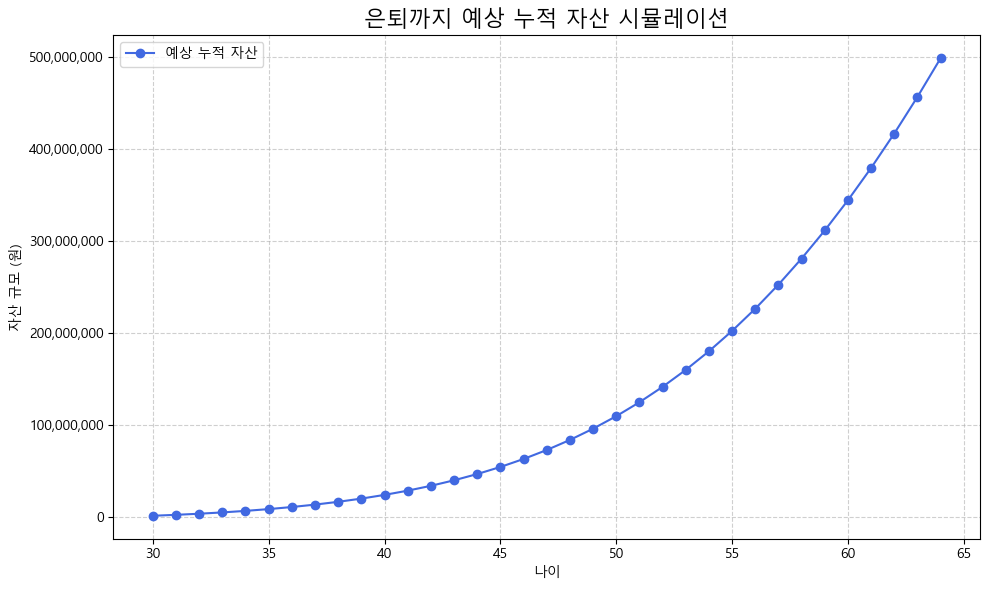


--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---


자산명,비중(%),월 투자금(원)
나스닥 100,39.48%,"26,023원"
GLD,48.81%,"32,173원"
KRX 채권지수 회사채 종합,11.71%,"7,722원"
종합,100.00%,"65,917원"


In [101]:
import pandas as pd
import numpy as np
import cvxpy as cp
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- 기존 코드와 동일한 부분 (설정 및 변수 추출) ---

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 파일 경로 (사용자 환경에 맞게 수정 필요)
# 이 코드를 실행하기 전에 'df_monthly_return' 데이터프레임이 미리 정의되어 있어야 합니다.
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"

# 2. 변수 추출
core_df = pd.read_excel(retirement_file, sheet_name='핵심 정보(가정,변수)', header=None)
core_df.columns = ['A', '항목', '값', '비고', 'E']
core_df = core_df[['항목', '값']].dropna()
core_df['값'] = pd.to_numeric(core_df['값'], errors='coerce')
variables = dict(core_df.set_index('항목')['값'])

current_age = int(variables['현재 나이'])
retire_age = int(variables['은퇴 나이'])
retire_years = int(variables['은퇴기간'])
inflation = float(variables['물가상승률(%)'])
gov_pension_monthly = float(variables['공무원연금(월) (현재시점)'])
target_monthly_spending = float(variables['최종 조정 목표 월별 소비금액'])
years_until_retirement = retire_age - current_age

# 3. 투자 성향
survey_df = pd.read_excel(retirement_file, sheet_name='r설문지 응답', header=None)
text_cells = survey_df.astype(str).values.flatten().tolist()
risk_types = ['안정형', '안정추구형', '위험중립형', '적극투자형', '공격투자형']
profile = next((r for cell in text_cells for r in risk_types if r in cell), '위험중립형')
vol_limit_map = {'안정형': 0.05, '안정추구형': 0.07, '위험중립형': 0.10, '적극투자형': 0.13, '공격투자형': 0.16}
target_vol = vol_limit_map[profile]

# 4. 자산 데이터 준비 (df_monthly_return이 정의되어 있다고 가정)
returns = df_monthly_return.dropna()
asset_names = returns.columns
n_assets = len(asset_names)
is_stock = np.array([0 if '채권' in name or '현금' in name else 1 for name in asset_names])

# --- ★★★ 핵심 수정 사항: TDF 로직 수정 ★★★ ---
def tdf_max_stock_ratio(current_year_index, total_years, max_ratio=0.9, min_ratio=0.3):
    """
    올바르게 수정된 TDF 글라이드패스 함수.
    '남은 기간'을 기준으로 주식 비중을 계산합니다.
    """
    # 기간 경과에 따라 주식 비중이 선형으로 감소
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

# 6. 기대수익률 및 공분산 계산 (EWMA 방식 적용)
span = 60
mu = returns.ewm(span=span).mean().iloc[-1].values * 12
cov = returns.ewm(span=span).cov().iloc[-n_assets:].values * 12

# 7. 연령별 기대수익률 계산
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # 수정된 함수 호출
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    w = cp.Variable(n_assets)
    constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= target_vol**2, is_stock @ w <= stock_limit]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()
    
    if w.value is not None:
        yearly_expected_return.append(mu @ w.value)
        yearly_opt_weights.append(w.value)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_safe = np.zeros(n_assets)
        w_safe[safe_asset_idx] = 1.0
        yearly_expected_return.append(mu @ w_safe)
        yearly_opt_weights.append(w_safe)

# 8. 필요 은퇴자금 계산
fv_spending = target_monthly_spending * (1 + inflation) ** years_until_retirement
fv_gov_pension = gov_pension_monthly * (1 + inflation) ** years_until_retirement
monthly_gap = max(fv_spending - fv_gov_pension, 0)
total_required = monthly_gap * 12 * retire_years

# 9. 이진 탐색으로 월 투자금 계산
def simulate_retirement_fund(monthly_invest, rate_list):
    fund = 0
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
    return fund

low, high = 1, 10_000_000
while high - low > 1000:
    mid = (low + high) // 2
    if simulate_retirement_fund(mid, yearly_expected_return) > total_required:
        high = mid
    else:
        low = mid
monthly_invest_final = high

# 10. 자산 누적 시뮬레이션 및 시각화
def simulate_asset_path(monthly_invest, rate_list):
    fund = 0
    path = []
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
        path.append(fund)
    return path

asset_path = simulate_asset_path(monthly_invest_final, yearly_expected_return)
ages = list(range(current_age, retire_age))

plt.figure(figsize=(10, 6))
plt.plot(ages, asset_path, label="예상 누적 자산", marker='o', color='royalblue')
plt.xlabel("나이")
plt.ylabel("자산 규모 (원)")
plt.title("은퇴까지 예상 누적 자산 시뮬레이션", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

# 11. 최종 자산 배분 및 월 투자금 요약
final_weights = yearly_opt_weights[0]
amounts_by_asset = final_weights * monthly_invest_final
asset_result = pd.DataFrame({
    '자산명': asset_names,
    '비중(%)': final_weights * 100,
    '월 투자금(원)': amounts_by_asset
})
asset_result = asset_result[asset_result['비중(%)'] > 0.1].round(2)

total_row = pd.DataFrame({
    '자산명': ['종합'],
    '비중(%)': [asset_result['비중(%)'].sum()],
    '월 투자금(원)': [asset_result['월 투자금(원)'].sum()]
})
asset_result = pd.concat([asset_result, total_row], ignore_index=True)

print("\n--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---")
display(asset_result.style.format({'비중(%)': '{:,.2f}%', '월 투자금(원)': '{:,.0f}원'}).hide(axis="index"))



In [102]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- 1. 이전 셀에서 계산된 변수들이 필요합니다 ---
# 이 코드를 실행하기 전에 mu, cov, target_vol, years_until_retirement, 
# ages, asset_names, tdf_max_stock_ratio 함수 등이 정의되어 있어야 합니다.

# --- 2. 연령별 기대수익률 + 포트폴리오 기록용 테이블 생성 (수정된 로직) ---
yearly_stock_limit = []
yearly_target_vol = []
yearly_portfolio_vol = []
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # ★★★ 올바른 함수 호출 방식으로 수정 ★★★
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    
    w = cp.Variable(n_assets)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.quad_form(w, cov) <= target_vol**2,
        is_stock @ w <= stock_limit
    ]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()

    if w.value is not None:
        w_opt = w.value
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_opt = np.zeros(n_assets)
        w_opt[safe_asset_idx] = 1.0
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)

    yearly_stock_limit.append(stock_limit)
    yearly_target_vol.append(target_vol)
    yearly_expected_return.append(r)
    yearly_portfolio_vol.append(vol)
    yearly_opt_weights.append(w_opt)

# --- 3. 기대수익률 테이블 만들기 ---
table_df = pd.DataFrame({
    '나이': ages,
    '주식 상한(%)': np.round(np.array(yearly_stock_limit) * 100, 1),
    '변동성 제한(%)': np.round(np.array(yearly_target_vol) * 100, 1),
    '기대수익률(%)': np.round(np.array(yearly_expected_return) * 100, 2),
    '포트폴리오 변동성(%)': np.round(np.array(yearly_portfolio_vol) * 100, 2)
})

print("\n--- 📋 연령별 투자 전략 요약 테이블 ---")
# display 함수는 Jupyter Notebook 환경에서 표를 예쁘게 보여줍니다.
display(table_df.style.format("{:,.2f}"))




--- 📋 연령별 투자 전략 요약 테이블 ---


,나이,주식 상한(%),변동성 제한(%),기대수익률(%),포트폴리오 변동성(%)
0,30.00,88.30,10.00,17.55,10.00
1,31.00,86.60,10.00,17.33,10.00
2,32.00,84.90,10.00,17.11,10.00
3,33.00,83.10,10.00,16.87,10.00
4,34.00,81.40,10.00,16.63,10.00
5,35.00,79.70,10.00,16.39,10.00
6,36.00,78.00,10.00,16.15,10.00
7,37.00,76.30,10.00,15.91,10.00
8,38.00,74.60,10.00,15.66,10.00
9,39.00,72.90,10.00,15.41,10.00



--- 📋 연령별 상세 자산 배분 계획표 (%) ---


,나스닥 100,GLD,KRX 채권지수 회사채 종합
30,39.5%,48.8%,11.7%
31,41.7%,44.9%,13.4%
32,43.3%,41.6%,15.1%
33,44.6%,38.6%,16.9%
34,45.6%,35.8%,18.6%
35,46.5%,33.2%,20.3%
36,47.2%,30.8%,22.0%
37,47.8%,28.5%,23.7%
38,48.4%,26.2%,25.4%
39,48.8%,24.0%,27.1%


c:\Users\tjw71\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


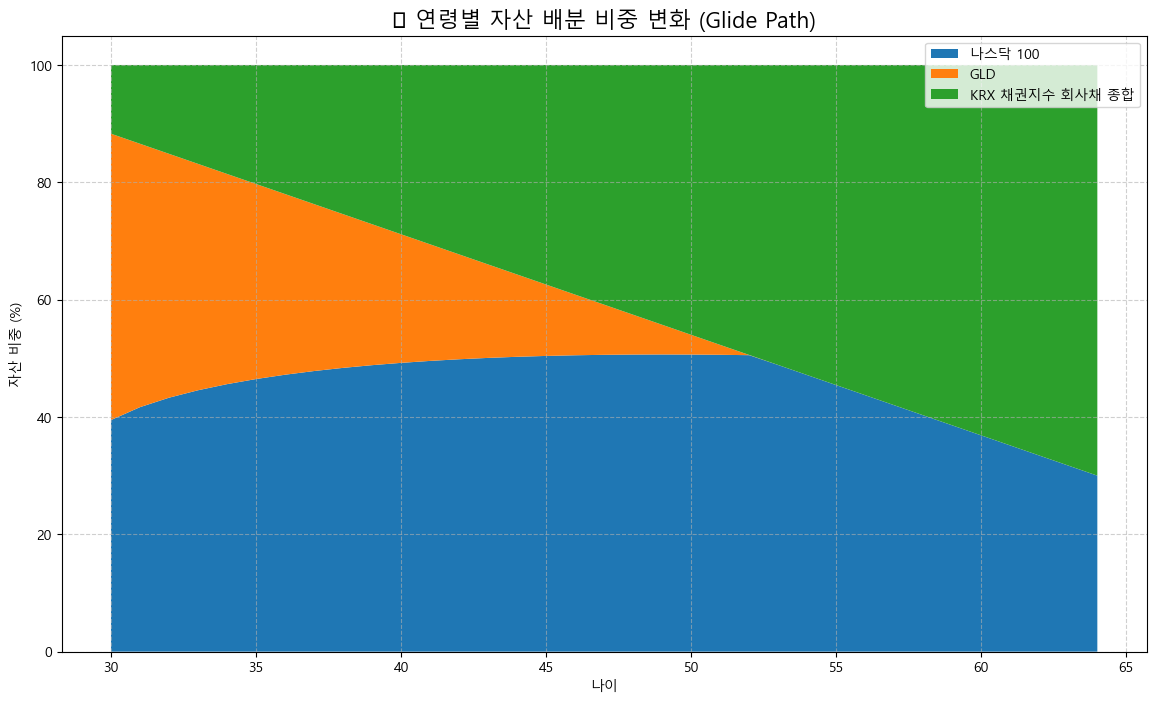

In [103]:
# --- 2. 연도별 포트폴리오 상세 계획표 생성 ---

# 연령별 최적 비중을 DataFrame으로 변환
weights_df = pd.DataFrame(yearly_opt_weights, index=ages, columns=asset_names)

# 비중이 0.1% 이상이었던 자산만 필터링하여 보기 쉽게 만듭니다.
weights_df = weights_df.loc[:, (weights_df > 0.001).any(axis=0)]
weights_df *= 100 # 백분율로 변환

print("\n--- 📋 연령별 상세 자산 배분 계획표 (%) ---")
display(weights_df.style.format("{:,.1f}%"))


# --- 3. 스택형 영역 차트로 시각화 ---

plt.figure(figsize=(14, 8))
plt.stackplot(weights_df.index, weights_df.T, labels=weights_df.columns)
plt.legend(loc='upper right')
plt.title('📈 연령별 자산 배분 비중 변화 (Glide Path)', fontsize=16)
plt.xlabel('나이')
plt.ylabel('자산 비중 (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 4. 종합설계

### 4-1. 재무목표 도출

In [104]:
# %%
# 은퇴 목표 정보 구성 (GPT용)
retirement_goal_description = f"""
- 은퇴 목표 시점: 만 {retire_age}세
- 은퇴 기간: {retire_years}년
- 목표 생활비: 월 {int(target_monthly_spending):,}원
- 예상 총 필요 은퇴자금: 약 {int(total_required):,}원
- 예상 연금 수령: 월 {int(gov_pension_monthly):,}원
"""
print(retirement_goal_description)



- 은퇴 목표 시점: 만 65세
- 은퇴 기간: 35년
- 목표 생활비: 월 2,500,000원
- 예상 총 필요 은퇴자금: 약 496,529,103원
- 예상 연금 수령: 월 2,000,000원



In [105]:
import openai
import ast
import re
import json
import os

# ==============================================================================
# ⭐️ 1. AI 응답 검증 및 정규화 함수 (수정된 버전)
# ==============================================================================
def validate_and_normalize_goals(parsed_list, source_ai_version="1차"):
    """
    AI가 생성한 목표 리스트를 검증하고, 백테스팅에 사용할 수 있는
    표준 형식({'name', 'years', 'target', 'priority', 'necessity'})으로 변환합니다.
    """
    cleaned_goal_list = []
    
    def extract_years(time_frame_value):
        if isinstance(time_frame_value, (int, float)): return int(time_frame_value)
        if isinstance(time_frame_value, str):
            numbers = re.findall(r'\d+', time_frame_value)
            return int(numbers[0]) if numbers else None
        return None

    for item in parsed_list:
        name = item.get('name') or item.get('목표명')
        target = item.get('target') or item.get('goal_amount')
        time_value = item.get('time_frame') or item.get('years')
        years = extract_years(time_value)
        
        # ⭐️ 중요: 우선순위와 필수성 정보를 반드시 가져오도록 수정
        priority = item.get('priority')
        necessity = item.get('necessity')

        # 1차 AI 응답에서는 모든 정보가 필수입니다.
        if not all([name, target, years, priority, necessity]):
            print(f"⚠️ 경고 ({source_ai_version} AI): '{name or '이름 없는'}' 목표에서 필수 정보(이름, 금액, 기간, 우선순위, 필수성)가 누락/유효하지 않아 제외합니다.")
            continue
            
        cleaned_goal_list.append({
            'name': name, 
            'years': int(years), 
            'target': int(target), 
            'is_short_term': int(years) <= 1,
            'priority': priority, 
            'necessity': necessity
        })
    return cleaned_goal_list

In [106]:
GOAL_LIST_SCHEMA = {
    "name": "goal_list_v1",
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "goals": {
                "type": "array",
                "items": {
                    "type": "object",
                    "additionalProperties": False,
                    "properties": {
                        "name":       {"type": "string", "description": "목표 이름"},
                        "years":      {"type": "integer", "minimum": 1, "maximum": 50, "description": "달성까지 남은 연수"},
                        "target":     {"type": "integer", "minimum": 0, "description": "목표 금액(원)"},
                        "priority":   {"type": "integer", "minimum": 1, "maximum": 5, "description": "우선순위(1=최상)"},
                        "necessity":  {"type": "string", "enum": ["필수","선택"], "description": "필수 여부"}
                    },
                    "required": ["name","years","target","priority","necessity"]
                }
            }
        },
        "required": ["goals"]
    },
    "strict": True
}

# ==============================================================================
# 2. 메인 실행 로직 (기존과 동일하되, LLM 호출/파싱만 교체)
# ==============================================================================
cache_file_path = "financial_goals_cache.json"
goal_list = []

if os.path.exists(cache_file_path):
    print(f"✅ 캐시 파일({cache_file_path})을 발견했습니다. API 호출 없이 데이터를 불러옵니다.")
    with open(cache_file_path, 'r', encoding='utf-8') as f:
        goal_list = json.load(f)
else:
    print(f"ℹ️ 캐시 파일이 없습니다. OpenAI API를 호출하여 재무 목표를 생성합니다.")
    
    savings_capacity = avg_cash_surplus  # 기존 변수 그대로 사용

    # ✅ 스키마 필드명에 맞춘 지시 (중괄호 이스케이프 주의!)
    system_prompt = f"""
    당신은 FPSB 공인 CFP 자격을 보유한 재무설계 전문가이며, 고객 재무목표 설계 알고리즘을 위한 전문가 자문 역할을 수행합니다.

    **[최상위 제약]**
    - 모든 재무 목표를 달성하기 위한 월 필요 저축액의 총합은 고객의 월 저축/투자 가능 금액인 {savings_capacity:,.0f}원을 절대 초과하지 않아야 합니다.

    **[출력 형식(중요)]**
    - 아래 스키마에 '정확히' 맞춰 **객체**를 출력하세요. 추가 키 금지.
    - 최상위는 {{\"goals\": [...]}} 형태이며, goals는 다음 항목들의 배열입니다:
    {{name:str, years:int, target:int, priority:int(1~5), necessity:\"필수\"|\"선택\"}}

    **[세부 수행 지침]**
    1. 고객의 재무상태, 생애주기, 소득수준, 소비/부채 구조, 투자성향 및 재무지식 수준을 종합 분석.
    2. CFP 국제 기준 및 한국형 실무 원칙에 따라 필요한 재무목표들을 도출.
    3. 각 목표는 다음 필드를 사용:
    - name: 목표 이름
    - years: 목표 달성까지 남은 연수(정수, 년 단위)
    - target: 목표 금액(원, 정수)
    - priority: 1~5 (1이 최상)
    - necessity: "필수" 또는 "권장"
    4. 고객이 직접 제시한 목표가 있어도, **월 {savings_capacity:,.0f}원** 한도 내 달성이 가능하도록 금액/기간을 조정(근거는 내부적으로 고려하되 출력에는 포함하지 않음).
    5. 1/3/5/10년 등 일반 저축 목표는 고객의 소득/지출 구조를 반영한 현실적 권고 수준으로 설정.
    6. 재무건전성/유동성/생애주기를 반영해 합리적 우선순위 부여.
    7. 아래 '은퇴 관련 목표 정보'는 내용 수정 없이 **중요도 판단만 반영**.

    **[응답 규칙]**
    - 설명 문장, 마크다운, 코드블록, 주석 없이 **JSON 객체만** 출력.
    - 최상위에 "goals" 배열을 포함할 것.
    - 스키마에 정의되지 않은 키는 절대 포함하지 말 것.
    """


    user_prompt = f"""
    [고객 프로필 정보]\n{client_profile}\n
    [설문 응답 정보]\n{survey_answers}\n
    [은퇴 관련 목표 정보]\n{retirement_goal_description}
    """

    try:
        # ✅ 키 하드코딩 금지: 환경변수 사용 권장 (예: OPENAI_API_KEY)
        client = openai.OpenAI()  

        # ✅ 구조화 출력: 스키마 강제
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.5,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_schema", "json_schema": GOAL_LIST_SCHEMA}
        )

        raw_json = response.choices[0].message.content
        parsed = json.loads(raw_json)
        goal_list = parsed["goals"]  # ← 래퍼에서 goals만 꺼냄


        # (선택) 후속 검증/보정 훅: 기존 함수를 슬림화해서 유지하고 싶다면 아래 라인 주석 해제
        # goal_list = validate_and_normalize_goals(goal_list, source_ai_version="구조화")

        # 캐시 저장
        if goal_list:
            with open(cache_file_path, 'w', encoding='utf-8') as f:
                json.dump(goal_list, f, ensure_ascii=False, indent=4)
            print(f"\n✅ 구조화 응답을 '{cache_file_path}' 파일에 저장했습니다.")
        else:
            print("\n⚠️ 유효한 재무 목표가 비어 있습니다.")

    except Exception as e:
        print(f"\n⚠️ API 호출 또는 파싱 중 오류가 발생했습니다: {e}")

if goal_list:
    print("\n✅ 최종 생성된 재무 목표 'goal_list':")
    print(goal_list)
else:
    print("\n⚠️ 'goal_list'가 생성되지 않았습니다. API 응답 또는 캐시 파일을 확인해주세요.")


✅ 캐시 파일(financial_goals_cache.json)을 발견했습니다. API 호출 없이 데이터를 불러옵니다.

✅ 최종 생성된 재무 목표 'goal_list':
[{'name': '단기 저축 목표', 'years': 5, 'target': 100000000, 'priority': 2, 'necessity': '필수'}, {'name': '은퇴 자금 마련', 'years': 35, 'target': 496529103, 'priority': 1, 'necessity': '필수'}, {'name': '여행 자금', 'years': 1, 'target': 20000000, 'priority': 3, 'necessity': '선택'}, {'name': '자녀 교육 자금', 'years': 10, 'target': 300000000, 'priority': 4, 'necessity': '선택'}, {'name': '부동산 투자 자금', 'years': 5, 'target': 200000000, 'priority': 5, 'necessity': '선택'}]


In [107]:
import pandas as pd
import numpy as np

# 0) goal_list를 DataFrame으로 통일
if isinstance(goal_list, pd.DataFrame):
    df = goal_list.copy()
elif isinstance(goal_list, list):
    df = pd.DataFrame(goal_list)
else:
    raise TypeError("goal_list는 list 또는 pandas.DataFrame이어야 합니다.")

# 1) 컬럼 타입/결측 방어
df["necessity"] = df.get("necessity", "선택").fillna("선택")
df["priority"]  = pd.to_numeric(df.get("priority", 99), errors="coerce").fillna(99).astype(int)
df["years"]     = pd.to_numeric(df.get("years", 0), errors="coerce").fillna(0).astype(int)

# 2) 기간 구간 컬럼
def categorize_years(years: int) -> str:
    if years <= 3:
        return "단기"
    elif years <= 10:
        return "중기"
    else:
        return "장기"

df["기간구분"] = df["years"].apply(categorize_years)

# 3) 필수→선택 정렬을 위한 매핑
necessity_order = {"필수": 0, "선택": 1}
df["necessity_order"] = df["necessity"].map(necessity_order).fillna(1).astype(int)

# 4) 정렬: 필수→선택, priority 오름차순
goal_list_sorted = (
    df.sort_values(by=["necessity_order", "priority"], ascending=[True, True])
      .drop(columns=["necessity_order"])
      .reset_index(drop=True)
)

display(goal_list_sorted)


,name,years,target,priority,necessity,기간구분
0,은퇴 자금 마련,35,496529103,1,필수,장기
1,단기 저축 목표,5,100000000,2,필수,중기
2,여행 자금,1,20000000,3,선택,단기
3,자녀 교육 자금,10,300000000,4,선택,중기
4,부동산 투자 자금,5,200000000,5,선택,중기


### 4-2. 재무목표별 포트폴리오 최적화 및 월별 금액 조정

In [118]:
# =================================================================
#  4-2. 통합 최적화 기반 재무 목표 및 포트폴리오 동시 설계 (최종 완성본)
# =================================================================
import pandas as pd
import numpy as np
import cvxpy as cp

# --- 1. 사전 변수 및 자산군 재정의 (이전과 동일) ---
total_monthly_budget = int(avg_cash_surplus)
goals_df = goal_list_sorted.copy()

HOUSING_DEPOSIT = 100000
HOUSING_RATE = 0.045
DOAK_MAX_MONTHLY = 700000
yla_calculator = YouthLeapAccount(household_file_path='손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm')
monthly_contribution = yla_calculator.calculate_contribution(DOAK_MAX_MONTHLY)
annual_contribution_yield = (monthly_contribution * 12) / (DOAK_MAX_MONTHLY * 12) if DOAK_MAX_MONTHLY > 0 else 0
base_rate_assumed = 0.045
doak_effective_rate = annual_contribution_yield + base_rate_assumed

print(f"\n✅ 청년도약계좌 월 기여금: {monthly_contribution:,.0f}원")
print(f"✅ 정부기여금 기반 추가 수익률: {annual_contribution_yield:.2%}")
print(f"✅ 최종 기대수익률 (기본금리 4.5% 가정): {doak_effective_rate:.2%}\n")

✅ 고객님의 추정 연소득: 43,556,942원
✅ 적용 소득구간: 총급여 4,800만원 이하

✅ 청년도약계좌 월 기여금: 25,200원
✅ 정부기여금 기반 추가 수익률: 3.60%
✅ 최종 기대수익률 (기본금리 4.5% 가정): 8.10%



In [123]:
asset_cols

['KOSPI',
 'KOSPI200',
 'KOSDAQ',
 'S&P 500',
 '나스닥 100',
 'CSI 300',
 '니케이 225',
 '유로스톡스50',
 'GLD',
 'KRX 채권지수 국채 3M~1Y',
 'KRX 채권지수 국채 2Y~3Y',
 'KRX 채권지수 국채 3Y~5Y',
 'KRX 채권지수 국채 5Y~10Y',
 'KRX 채권지수 회사채 종합']

In [120]:
final_asset_cols = asset_cols + ['청년 주택드림 청약통장', '청년도약계좌']
n_assets = len(final_asset_cols)
mu_final = np.append(mu, [HOUSING_RATE, doak_effective_rate])
cov_final = np.zeros((n_assets, n_assets))
cov_final[:len(cov), :len(cov)] = cov
is_stock_final = np.append(is_stock, [0, 0])

final_asset_cols

['KOSPI',
 'KOSPI200',
 'KOSDAQ',
 'S&P 500',
 '나스닥 100',
 'CSI 300',
 '니케이 225',
 '유로스톡스50',
 'GLD',
 'KRX 채권지수 국채 3M~1Y',
 'KRX 채권지수 국채 2Y~3Y',
 'KRX 채권지수 국채 3Y~5Y',
 'KRX 채권지수 국채 5Y~10Y',
 'KRX 채권지수 회사채 종합',
 '청년 주택드림 청약통장',
 '청년도약계좌']

In [122]:
# =================================================================
#  4-2. 통합 최적화 기반 재무 목표 및 포트폴리오 동시 설계 (최종 완성본)
# =================================================================
import pandas as pd
import numpy as np
import cvxpy as cp
import numpy_financial as npf # ★★★★★ 오류 수정: numpy_financial 라이브러리 import ★★★★★
from typing import Dict, Tuple

# --- 1. 청년도약계좌 클래스 정의 ---
YLA_BANDS_INFO = {
    2400: {"max_contribution": 24000, "rate_at_400k": 0.060, "max_total_contribution": 33000},
    3600: {"max_contribution": 23000, "rate_at_400k": 0.046, "max_total_contribution": 29000},
    4800: {"max_contribution": 22200, "rate_at_400k": 0.037, "max_total_contribution": 25200},
    6000: {"max_contribution": 21000, "rate_at_400k": 0.030, "max_total_contribution": 21000},
    7500: {"max_contribution": 0,     "rate_at_400k": 0.0,   "max_total_contribution": 0},
}
YLA_CAP_RATE_AT_600K = 0.030

class YouthLeapAccount:
    def __init__(self, household_file_path: str):
        self.household_file_path = household_file_path
        self.annual_salary = self._get_annual_salary()
        self.income_band_key = self._get_income_band_key()
        print(f"✅ 고객님의 추정 연소득: {self.annual_salary:,.0f}원")
        print(f"✅ 적용 소득구간: 총급여 {self.income_band_key:,}만원 이하")

    def _get_annual_salary(self) -> float:
        df = pd.read_excel(self.household_file_path, sheet_name='뱅샐현황', usecols="E:J", engine='openpyxl')
        monthly_salary = df.iloc[17].mean()
        return monthly_salary * 12

    def _get_income_band_key(self) -> int:
        salary_in_mn = self.annual_salary / 10000
        for band_max in sorted(YLA_BANDS_INFO.keys()):
            if salary_in_mn <= band_max: return band_max
        return max(YLA_BANDS_INFO.keys())

    def calculate_contribution(self, monthly_deposit: int) -> int:
        band_info = YLA_BANDS_INFO.get(self.income_band_key)
        if not band_info or monthly_deposit <= 0: return 0
        if monthly_deposit >= 700000:
            return band_info["max_total_contribution"]
        if self.income_band_key <= 4800 and monthly_deposit > 400000:
            base_contribution = band_info["max_contribution"]
            additional_deposit = min(monthly_deposit - 400000, 300000)
            additional_contribution = round(additional_deposit * 0.03)
            return min(base_contribution + additional_contribution, band_info["max_total_contribution"])
        return min(int(round(monthly_deposit * band_info["rate_at_400k"])), band_info["max_contribution"])

# --- 2. 사전 변수 및 자산군 재정의 ---
total_monthly_budget = int(avg_cash_surplus)
goals_df = goal_list_sorted.copy()

HOUSING_DEPOSIT = 100000
HOUSING_RATE = 0.045
DOAK_MAX_MONTHLY = 700000
yla_calculator = YouthLeapAccount(household_file_path='손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm')
monthly_contribution = yla_calculator.calculate_contribution(DOAK_MAX_MONTHLY)
annual_contribution_yield = (monthly_contribution * 12) / (DOAK_MAX_MONTHLY * 12) if DOAK_MAX_MONTHLY > 0 else 0
base_rate_assumed = 0.045
doak_effective_rate = annual_contribution_yield + base_rate_assumed

print(f"\n✅ 청년도약계좌 월 기여금: {monthly_contribution:,.0f}원")
print(f"✅ 정부기여금 기반 추가 수익률: {annual_contribution_yield:.2%}")
print(f"✅ 최종 기대수익률 (기본금리 4.5% 가정): {doak_effective_rate:.2%}\n")

final_asset_cols = asset_cols + ['청년 주택드림 청약통장', '청년도약계좌']
n_assets = len(final_asset_cols)
mu_final = np.append(mu, [HOUSING_RATE, doak_effective_rate])
cov_final = np.zeros((n_assets, n_assets))
cov_final[:len(cov), :len(cov)] = cov
is_stock_final = np.append(is_stock, [0, 0])

# --- 3. 최적화 문제 정의 (제약 조건 추가 및 pmt 함수 수정) ---
n_goals = len(goals_df)
allocations = cp.Variable((n_goals, n_assets), nonneg=True)
fulfillment_ratios = cp.Variable(n_goals, nonneg=True)

# ★★★★★ 오류 수정: np.pmt 대신 npf.pmt 사용 ★★★★★
goals_df['월 필요원금'] = goals_df.apply(lambda row: npf.pmt(HOUSING_RATE/12, row['years']*12, 0, -row['target']), axis=1)
required_amounts = goals_df['월 필요원금'].values
priority_weights = 6 - goals_df['priority'].values

constraints = [
    cp.sum(allocations) <= total_monthly_budget,
    fulfillment_ratios <= 1,
    cp.sum(allocations[:, -2]) <= HOUSING_DEPOSIT,
    cp.sum(allocations[:, -1]) <= DOAK_MAX_MONTHLY,
]

doak_asset_index = final_asset_cols.index('청년도약계좌')

for i in range(n_goals):
    constraints.append(cp.sum(allocations[i, :]) == required_amounts[i] * fulfillment_ratios[i])
    
    goal_total_alloc = cp.sum(allocations[i, :])
    weights = allocations[i, :] / (goal_total_alloc + 1e-9)
    stock_limit = tdf_fn(0, goals_df['years'].iloc[i])
    constraints.append(is_stock_final @ weights <= stock_limit)
    constraints.append(cp.quad_form(weights, cov_final) <= target_vol**2)
    
    if goals_df['years'].iloc[i] > 5:
        constraints.append(allocations[i, doak_asset_index] == 0)

objective = cp.Maximize(priority_weights @ fulfillment_ratios)

# --- 4. 최적화 문제 해결 ---
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.SCS, verbose=False)

# --- 5. 최종 결과 종합 및 출력 ---
print("\n" + "="*60)
print(" 종합 요약: 통합 최적화 기반 재무 목표 및 포트폴리오 구성")
print("="*60)

if prob.status in ["optimal", "optimal_inaccurate"]:
    final_allocations = pd.DataFrame(allocations.value, index=goals_df['name'], columns=final_asset_cols)
    final_allocations = final_allocations.loc[(final_allocations.sum(axis=1) > 1), (final_allocations.sum(axis=0) > 1)]

    final_fulfillment = pd.DataFrame({
        '목표명': goals_df['name'],
        '달성률(%)': fulfillment_ratios.value * 100,
        '월 필요액': goals_df['월 필요원금'],
        '조정된 월 배분액': np.sum(allocations.value, axis=1)
    }).set_index('목표명')

    final_summary_df = final_fulfillment.join(final_allocations).reset_index()
    
    total_row = pd.DataFrame([{'목표명': '종합', '조정된 월 배분액': final_summary_df['조정된 월 배분액'].sum()}])
    final_display_df = pd.concat([final_summary_df, total_row], ignore_index=True)

    print(f"총 월 저축/투자 가능액: {total_monthly_budget:,.0f}원")
    print(f"최종 배분액 합계: {final_display_df.loc[final_display_df['목표명'] == '종합', '조정된 월 배분액'].iloc[0]:,.0f}원")
    
    print("\n--- 📋 최종 월 투자 배분 계획 ---")
    display(final_display_df.style.format({
        '달성률(%)': '{:.1f}%',
        '월 필요액': '{:,.0f}원',
        '조정된 월 배분액': '{:,.0f}원',
        **{col: '{:,.0f}' for col in final_allocations.columns}
    }, na_rep='').hide(axis="index"))
else:
    print(f"⚠️ 최적화 문제를 해결하지 못했습니다. (상태: {prob.status})")
    print("   현실적으로 달성 불가능한 목표가 있거나 제약 조건이 너무 엄격할 수 있습니다.")

✅ 고객님의 추정 연소득: 43,556,942원
✅ 적용 소득구간: 총급여 4,800만원 이하

✅ 청년도약계좌 월 기여금: 25,200원
✅ 정부기여금 기반 추가 수익률: 3.60%
✅ 최종 기대수익률 (기본금리 4.5% 가정): 8.10%



DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] @ (var86294[0, 0:16] / Promote(Sum(var86294[0, 0:16], None, False) + 1e-09, (16,))) <= 0.882857142857143 , because the following subexpressions are not:
|--  var86294[0, 0:16] / Promote(Sum(var86294[0, 0:16], None, False) + 1e-09, (16,))
QuadForm(var86294[0, 0:16] / Promote(Sum(var86294[0, 0:16], None, False) + 1e-09, (16,)), [[0.04 0.04 ... 0.00 0.00]
 [0.04 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]]) <= 0.010000000000000002 , because the following subexpressions are not:
|--  var86294[0, 0:16] / Promote(Sum(var86294[0, 0:16], None, False) + 1e-09, (16,))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] @ (var86294[1, 0:16] / Promote(Sum(var86294[1, 0:16], None, False) + 1e-09, (16,))) <= 0.78 , because the following subexpressions are not:
|--  var86294[1, 0:16] / Promote(Sum(var86294[1, 0:16], None, False) + 1e-09, (16,))
QuadForm(var86294[1, 0:16] / Promote(Sum(var86294[1, 0:16], None, False) + 1e-09, (16,)), [[0.04 0.04 ... 0.00 0.00]
 [0.04 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]]) <= 0.010000000000000002 , because the following subexpressions are not:
|--  var86294[1, 0:16] / Promote(Sum(var86294[1, 0:16], None, False) + 1e-09, (16,))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] @ (var86294[2, 0:16] / Promote(Sum(var86294[2, 0:16], None, False) + 1e-09, (16,))) <= 0.3 , because the following subexpressions are not:
|--  var86294[2, 0:16] / Promote(Sum(var86294[2, 0:16], None, False) + 1e-09, (16,))
QuadForm(var86294[2, 0:16] / Promote(Sum(var86294[2, 0:16], None, False) + 1e-09, (16,)), [[0.04 0.04 ... 0.00 0.00]
 [0.04 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]]) <= 0.010000000000000002 , because the following subexpressions are not:
|--  var86294[2, 0:16] / Promote(Sum(var86294[2, 0:16], None, False) + 1e-09, (16,))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] @ (var86294[3, 0:16] / Promote(Sum(var86294[3, 0:16], None, False) + 1e-09, (16,))) <= 0.8400000000000001 , because the following subexpressions are not:
|--  var86294[3, 0:16] / Promote(Sum(var86294[3, 0:16], None, False) + 1e-09, (16,))
QuadForm(var86294[3, 0:16] / Promote(Sum(var86294[3, 0:16], None, False) + 1e-09, (16,)), [[0.04 0.04 ... 0.00 0.00]
 [0.04 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]]) <= 0.010000000000000002 , because the following subexpressions are not:
|--  var86294[3, 0:16] / Promote(Sum(var86294[3, 0:16], None, False) + 1e-09, (16,))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.] @ (var86294[4, 0:16] / Promote(Sum(var86294[4, 0:16], None, False) + 1e-09, (16,))) <= 0.78 , because the following subexpressions are not:
|--  var86294[4, 0:16] / Promote(Sum(var86294[4, 0:16], None, False) + 1e-09, (16,))
QuadForm(var86294[4, 0:16] / Promote(Sum(var86294[4, 0:16], None, False) + 1e-09, (16,)), [[0.04 0.04 ... 0.00 0.00]
 [0.04 0.04 ... 0.00 0.00]
 ...
 [0.00 0.00 ... 0.00 0.00]
 [0.00 0.00 ... 0.00 0.00]]) <= 0.010000000000000002 , because the following subexpressions are not:
|--  var86294[4, 0:16] / Promote(Sum(var86294[4, 0:16], None, False) + 1e-09, (16,))

In [108]:
# =========================================================
#  4-2 (1 & 2): 포트폴리오 최적화 헬퍼 함수 (최종 수정본)
# =========================================================
import cvxpy as cp
import numpy as np
import pandas as pd
import re

# ★★★ NameError 해결: 고정 월 납입액 변수 정의 추가 ★★★
HOUSING_FIXED_MONTHLY = 100000  # 청약통장 월 10만원
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# ★★★ NameError 해결: asset_cols 변수 정의 추가 ★★★
# 이 셀 이전에 df_monthly_return이 정의되어 있어야 합니다.
if "df_monthly_return" not in globals():
    raise RuntimeError("오류: 이전 '자산군 정리' 섹션을 먼저 실행하여 'df_monthly_return'을 생성해야 합니다.")
asset_cols = df_monthly_return.columns.tolist()
n_assets = len(asset_cols)
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# ★★★ NameError 해결: tdf_fn 함수 정의를 여기에 직접 포함 ★★★
def tdf_max_stock_ratio(current_year_index, total_years, max_ratio=0.9, min_ratio=0.3):
    glide_ratio = ((total_years - 1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))
tdf_fn = tdf_max_stock_ratio
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★

# ★★★ NameError 해결: 안전한 표 출력을 위한 포맷터 함수 정의 추가 ★★★
def fmt_won(x):
    if isinstance(x, (int, float, np.integer, np.floating)):
        return f"{x:,.0f}원"
    try:
        if pd.isna(x): return ""
    except Exception:
        pass
    return x
def fmt_int(x):
    if isinstance(x, (int, np.integer)): return f"{x:d}"
    try:
        if pd.isna(x): return ""
    except Exception:
        pass
    return x
def safe_style(df: pd.DataFrame, won_cols=None, int_cols=None):
    won_cols = won_cols or []; int_cols = int_cols or []
    df2 = df.copy()
    for c in won_cols:
        if c in df2.columns: df2[c] = pd.to_numeric(df2[c], errors="coerce")
    for c in int_cols:
        if c in df2.columns: df2[c] = pd.to_numeric(df2[c], errors="coerce")
    sty = df2.style
    if won_cols: sty = sty.format({c: fmt_won for c in won_cols})
    if int_cols: sty = sty.format({c: fmt_int for c in int_cols})
    return sty.hide(axis="index")
# ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★


# --- 1. TDF 모델 기반, 연도별 기대수익률 경로 계산 함수 ---
# [65]번 셀
# 함수가 mu, cov 등 필요한 모든 변수를 인자로 받도록 시그니처를 수정합니다.
def get_expected_return_path(goal_years: int, mu, cov, is_stock, tdf_func, vol_target) -> list:
    yearly_returns = []
    # n_assets는 mu의 길이를 통해 함수 내부에서 정의할 수 있습니다.
    n_assets = len(mu)
    for i in range(goal_years):
        # tdf_fn 대신 전달받은 tdf_func를 사용합니다.
        stock_limit = tdf_func(current_year_index=i, total_years=goal_years)
        w = cp.Variable(n_assets)
        # 전역 변수 대신 전달받은 인자(mu, cov 등)를 사용합니다.
        constraints = [
            cp.sum(w) == 1, w >= 0,
            cp.quad_form(w, cov) <= vol_target**2,
            is_stock @ w <= stock_limit
        ]
        problem = cp.Problem(cp.Maximize(mu @ w), constraints)
        problem.solve(solver=cp.ECOS)
        
        if w.value is not None:
            yearly_returns.append(mu @ w.value)
        else:
            # 안전자산 인덱스를 찾을 때 asset_cols 대신 mu의 길이를 사용하거나,
            # asset_names도 인자로 전달받는 것이 더 좋습니다.
            # 여기서는 mu의 마지막 자산을 안전자산으로 가정하여 단순화하겠습니다.
            yearly_returns.append(mu[-1]) # 안전자산 수익률로 대체
    return yearly_returns


# --- 2. 특정 목표 달성을 위한 월 필요 투자금액 계산 함수 ---
def calculate_monthly_investment(target_amount: float, yearly_return_rates: list, initial_fund: float = 0.0) -> int:
    if target_amount <= 0: return 0
    low, high = 0, 10_000_000
    while high - low > 100:
        mid = (low + high) / 2
        fund = float(initial_fund)
        for r in yearly_return_rates:
            for _ in range(12):
                fund = fund * (1 + r / 12) + mid
        if fund >= target_amount:
            high = mid
        else:
            low = mid
    return int(high)

# --- 3. 미래가치(원리금) 시뮬레이션 함수 ---
def simulate_final_asset(monthly_invest: int, yearly_return_rates: list, start_fund: float = 0.0) -> float:
    fund = float(start_fund)
    for r in yearly_return_rates:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
    return fund

# --- 4. TDF 포트폴리오 최적 비중 계산 함수 (글라이드패스 리포트용) ---
def get_opt_weights_path(goal_years: int):
    weights = []
    for i in range(goal_years):
        stock_limit = tdf_fn(current_year_index=i, total_years=goal_years)
        w = cp.Variable(n_assets)
        constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= target_vol**2, is_stock @ w <= stock_limit]
        prob = cp.Problem(cp.Maximize(mu @ w), constraints)
        prob.solve(solver=cp.ECOS)
        w_opt = w.value if w.value is not None else np.zeros(n_assets)
        weights.append(np.clip(w_opt, 0, 1) / np.sum(np.clip(w_opt, 0, 1)))
    return weights

In [111]:
# =========================================================
#  4-2 (세 번째 셀): 원안(Original Plan) 계산
# =========================================================

# 이전 셀에서 정의된 goal_list_sorted를 사용합니다.
if "goal_list_sorted" not in globals():
    raise RuntimeError("오류: 이전 '재무목표 도출' 섹션의 셀을 먼저 실행해야 합니다.")

# 원안 월 필요액 계산
rows = []
for _, g in goal_list_sorted.iterrows():
    yrs = int(g["years"])
    tgt = float(g["target"])
    
    # 위 셀에서 정의된 헬퍼 함수들을 사용
        # [89]번 셀
    # 함수 정의에 맞게 모든 인자를 전달합니다.
    # 이 단계는 '원안' 계산이므로 _final이 붙지 않은 원본 변수를 사용합니다.
    path = get_expected_return_path(
        goal_years=yrs,
        mu=mu,
        cov=cov,
        is_stock=is_stock,
        tdf_func=tdf_fn,
        vol_target=target_vol
    )
    m_need = calculate_monthly_investment(tgt, path)
    
    rows.append({
        "목표명": g["name"], 
        "기간(년)": yrs, 
        "목표 금액(원)": tgt,
        "원안_월 필요(원)": m_need, 
        "필수성": g.get("necessity", "선택"),
        "우선순위": int(g["priority"])
    })

# 다음 셀에서 사용할 orig_df 변수 생성
orig_df = pd.DataFrame(rows).sort_values(["필수성", "우선순위"]).reset_index(drop=True)
total_required_orig_display = int(orig_df["원안_월 필요(원)"].sum())

print("▶ 1) 목표별 원안 월 필요 납입액")
# 합계 행을 추가하여 화면에 표시
display_df = pd.concat([
    orig_df,
    pd.DataFrame([{
        "목표명": "종합", "기간(년)": "", "목표 금액(원)": np.nan,
        "원안_월 필요(원)": total_required_orig_display, "필수성": "", "우선순위": ""
    }])
], ignore_index=True)

display(safe_style(
    display_df,
    won_cols=["목표 금액(원)", "원안_월 필요(원)"], 
    int_cols=["기간(년)"]
))

▶ 1) 목표별 원안 월 필요 납입액


목표명,기간(년),목표 금액(원),원안_월 필요(원),필수성,우선순위
여행 자금,1.0,20000000.000000,1601333,선택,3
자녀 교육 자금,10.0,300000000.000000,1324234,선택,4
부동산 투자 자금,5.0,200000000.000000,2505722,선택,5
은퇴 자금 마련,35.0,496529103.000000,65689,필수,1
단기 저축 목표,5.0,100000000.000000,1252899,필수,2
종합,,nan,6749877,,


In [117]:
# =================================================================
#  4-2. 재무목표별 포트폴리오 조정 로직 (잉여 자금 배분 최종본)
# =================================================================
import pandas as pd
import numpy as np

# --- 1, 2, 3 단계는 이전 코드와 동일 ---
total_monthly_budget = int(avg_cash_surplus)
original_goals_df = goal_list_sorted.copy()

required_monthly_list = []
for _, goal in original_goals_df.iterrows():
    path = get_expected_return_path(int(goal['years']), mu, cov, is_stock, tdf_fn, target_vol)
    required = calculate_monthly_investment(float(goal['target']), path)
    required_monthly_list.append(required)
original_goals_df['월 필요액'] = required_monthly_list

adjusted_goals_df = original_goals_df.copy()
excluded_goals = []

while adjusted_goals_df['월 필요액'].sum() > total_monthly_budget:
    optional_goals = adjusted_goals_df[adjusted_goals_df['necessity'] == '선택']
    if optional_goals.empty:
        break
    lowest_priority_goal = optional_goals.sort_values('priority', ascending=False).iloc[0]
    excluded_goals.append(lowest_priority_goal['name'])
    adjusted_goals_df = adjusted_goals_df.drop(lowest_priority_goal.name)

total_required_after_step1 = adjusted_goals_df['월 필요액'].sum()
if total_required_after_step1 > total_monthly_budget:
    retirement_goal = adjusted_goals_df[adjusted_goals_df['name'] == '은퇴 자금 마련']
    adjustable_essential_goals = adjusted_goals_df[(adjusted_goals_df['necessity'] == '필수') & (adjusted_goals_df['name'] != '은퇴 자금 마련')]

    if not adjustable_essential_goals.empty:
        retirement_needed = retirement_goal['월 필요액'].sum()
        adjustable_needed = adjustable_essential_goals['월 필요액'].sum()
        budget_for_adjustable = total_monthly_budget - retirement_needed
        
        if budget_for_adjustable > 0 and adjustable_needed > 0:
            adjustment_ratio = budget_for_adjustable / adjustable_needed
            adjusted_goals_df.loc[adjustable_essential_goals.index, '조정된 월 배분액'] = adjustable_essential_goals['월 필요액'] * adjustment_ratio
            adjusted_goals_df.loc[retirement_goal.index, '조정된 월 배분액'] = retirement_goal['월 필요액']
        else:
            adjusted_goals_df.loc[adjustable_essential_goals.index, '조정된 월 배분액'] = 0
            adjusted_goals_df.loc[retirement_goal.index, '조정된 월 배분액'] = total_monthly_budget
            
    else:
        adjusted_goals_df['조정된 월 배분액'] = total_monthly_budget
else:
    adjusted_goals_df['조정된 월 배분액'] = adjusted_goals_df['월 필요액']

# --- 4. 최종 결과 종합 및 잉여 자금 배분 로직 추가 ---
print("\n" + "="*60)
print(" 최종 요약: 규칙 기반 재무 목표별 포트폴리오 구성")
print("="*60)

print(f"총 월 저축/투자 가능액: {total_monthly_budget:,.0f}원")
print("실제 저축 여력을 고려하여 아래와 같이 포트폴리오를 조정합니다.")
if excluded_goals:
    print(f"  - 예산 제약으로 인해 다음 '선택' 목표는 제외됩니다: {excluded_goals}")

final_plan_df = adjusted_goals_df[['name', 'years', 'target', '월 필요액', '조정된 월 배분액', 'necessity', 'priority']].copy()
final_plan_df.rename(columns={
    'name': '목표명',
    'years': '기간(년)',
    'target': '목표 금액(원)'
}, inplace=True)

total_allocated_amount = final_plan_df['조정된 월 배분액'].sum()
surplus_amount = total_monthly_budget - total_allocated_amount

if surplus_amount > 1000:
    print(f"\n💡 필수 목표 달성 후 월 {surplus_amount:,.0f}원의 잉여 자금이 발생합니다.")
    print("   이 자금은 안정성과 추가 기회 확보를 위해 다음과 같이 배분하는 것을 추천합니다.")
    
    surplus_row = pd.DataFrame([{
        '목표명': '비상 예비 자금',
        'necessity': '필수(유동성)',
        'priority': 0,
        '조정된 월 배분액': surplus_amount
    }])
    final_plan_df = pd.concat([final_plan_df, surplus_row], ignore_index=True)


# 합계 행 생성
total_row = pd.DataFrame([{
    '목표명': '종합',
    '월 필요액': original_goals_df['월 필요액'].sum(),
    '조정된 월 배분액': final_plan_df['조정된 월 배분액'].sum()
}])
final_display_df = pd.concat([final_plan_df, total_row], ignore_index=True)

# ★★★★★ 오류 수정: 정렬 전에 priority를 숫자형으로 변환 ★★★★★
final_display_df['priority'] = pd.to_numeric(final_display_df['priority'], errors='coerce')
final_display_df = final_display_df.sort_values(by='priority', ascending=True, na_position='last').reset_index(drop=True)

display_columns = ['목표명', '기간(년)', '목표 금액(원)', '월 필요액', '조정된 월 배분액', 'necessity', 'priority']

print("\n--- 📋 최종 월 투자 배분 계획 ---")
display(final_display_df[display_columns].style.format({
    '목표 금액(원)': '{:,.0f}원',
    '월 필요액': '{:,.0f}원',
    '조정된 월 배분액': '{:,.0f}원',
    'priority': '{:.0f}',
    '기간(년)': '{:.0f}'
}, na_rep='').hide(axis="index"))


 최종 요약: 규칙 기반 재무 목표별 포트폴리오 구성
총 월 저축/투자 가능액: 1,612,893원
실제 저축 여력을 고려하여 아래와 같이 포트폴리오를 조정합니다.
  - 예산 제약으로 인해 다음 '선택' 목표는 제외됩니다: ['부동산 투자 자금', '자녀 교육 자금', '여행 자금']

💡 필수 목표 달성 후 월 294,305원의 잉여 자금이 발생합니다.
   이 자금은 안정성과 추가 기회 확보를 위해 다음과 같이 배분하는 것을 추천합니다.

--- 📋 최종 월 투자 배분 계획 ---


목표명,기간(년),목표 금액(원),월 필요액,조정된 월 배분액,necessity,priority
비상 예비 자금,,,,"294,305원",필수(유동성),0
은퇴 자금 마련,35,"496,529,103원","65,689원","65,689원",필수,1
단기 저축 목표,5,"100,000,000원","1,252,899원","1,252,899원",필수,2
종합,,,"6,749,877원","1,612,893원",,


In [110]:
# =================================================================
#  4-2. 재무목표별 포트폴리오 최적화 및 월별 금액 조정 (오류 수정 최종본)
# =================================================================
import pandas as pd
import numpy as np
import cvxpy as cp
from typing import Dict, Tuple

# --- 1. 청년도약계좌 클래스 정의 (수정 완료) ---
YLA_BANDS_INFO = {
    2400: {"max_contribution": 24000, "rate_at_400k": 0.060, "max_total_contribution": 33000},
    3600: {"max_contribution": 23000, "rate_at_400k": 0.046, "max_total_contribution": 29000},
    4800: {"max_contribution": 22200, "rate_at_400k": 0.037, "max_total_contribution": 25200},
    6000: {"max_contribution": 21000, "rate_at_400k": 0.030, "max_total_contribution": 21000},
    7500: {"max_contribution": 0,     "rate_at_400k": 0.0,   "max_total_contribution": 0},
}
YLA_CAP_RATE_AT_600K = 0.030

class YouthLeapAccount:
    def __init__(self, household_file_path: str):
        self.household_file_path = household_file_path
        self.annual_salary = self._get_annual_salary()
        self.income_band_key = self._get_income_band_key()
        print(f"✅ 고객님의 추정 연소득: {self.annual_salary:,.0f}원")
        print(f"✅ 적용 소득구간: 총급여 {self.income_band_key:,}만원 이하")

    def _get_annual_salary(self) -> float:
        df = pd.read_excel(self.household_file_path, sheet_name='뱅샐현황', usecols="E:J", engine='openpyxl')
        monthly_salary = df.iloc[17].mean()
        return monthly_salary * 12

    def _get_income_band_key(self) -> int:
        salary_in_mn = self.annual_salary / 10000
        for band_max in sorted(YLA_BANDS_INFO.keys()):
            if salary_in_mn <= band_max: return band_max
        return max(YLA_BANDS_INFO.keys())

    def calculate_contribution(self, monthly_deposit: int) -> int:
        band_info = YLA_BANDS_INFO.get(self.income_band_key)
        if not band_info or monthly_deposit <= 0: return 0
        if monthly_deposit >= 700000:
            return band_info["max_total_contribution"]
        if self.income_band_key <= 4800 and monthly_deposit > 400000:
            base_contribution = band_info["max_contribution"]
            additional_deposit = min(monthly_deposit - 400000, 300000)
            additional_contribution = round(additional_deposit * 0.03)
            return min(base_contribution + additional_contribution, band_info["max_total_contribution"])
        return min(int(round(monthly_deposit * band_info["rate_at_400k"])), band_info["max_contribution"])

# --- 2. 최적화 헬퍼 함수 정의 (이전 셀에서 정의되었으므로 여기서는 생략) ---
# get_expected_return_path, get_opt_weights_path, calculate_monthly_investment 함수가
# 이 셀 이전에 정의되어 있다고 가정합니다.

# --- 3. 사전 변수 로드 및 최종 자산군 재정의 (수익률 계산 수정) ---
total_monthly_budget = int(avg_cash_surplus)
original_goals_df = goal_list_sorted.copy()
HOUSING_FIXED_MONTHLY = 100000
DOAK_MAX_MONTHLY = 700000

yla_calculator = YouthLeapAccount(household_file_path='손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm')
monthly_contribution = yla_calculator.calculate_contribution(DOAK_MAX_MONTHLY)
annual_contribution_yield = (monthly_contribution * 12) / (DOAK_MAX_MONTHLY * 12) if DOAK_MAX_MONTHLY > 0 else 0
base_rate_assumed = 0.045
doak_effective_rate = annual_contribution_yield + base_rate_assumed

print(f"\n✅ 청년도약계좌 월 기여금: {monthly_contribution:,.0f}원")
print(f"✅ 정부기여금 기반 추가 수익률: {annual_contribution_yield:.2%}")
print(f"✅ 최종 기대수익률 (기본금리 4.5% 가정): {doak_effective_rate:.2%}\n")

final_asset_cols = asset_cols + ['청년도약계좌']
n_final_assets = len(final_asset_cols)
mu_final = np.append(mu, doak_effective_rate)
cov_final = np.zeros((n_final_assets, n_final_assets))
cov_final[:n_assets, :n_assets] = cov
is_stock_final = np.append(is_stock, 0)

# --- 4. 예산 현실화를 위한 목표 조정 (함수 호출 인자 수정) ---
required_monthly_list = []
for _, goal in original_goals_df.iterrows():
    # ★★★★★ 오류 수정: get_expected_return_path 함수에 모든 인자를 정확히 전달 ★★★★★
    path = get_expected_return_path(
        goal_years=int(goal['years']),
        mu=mu_final,
        cov=cov_final,
        is_stock=is_stock_final,
        tdf_func=tdf_fn,
        vol_target=target_vol
    )
    required = calculate_monthly_investment(float(goal['target']), path)
    required_monthly_list.append(required)
original_goals_df['원안_월 필요(원)'] = required_monthly_list

achievable_goals_df = original_goals_df.copy()
while achievable_goals_df['원안_월 필요(원)'].sum() > total_monthly_budget:
    optional_goals = achievable_goals_df[achievable_goals_df['necessity'] == '선택']
    if optional_goals.empty: break
    lowest_priority_optional = optional_goals.sort_values('priority', ascending=False).iloc[0]
    achievable_goals_df = achievable_goals_df.drop(lowest_priority_optional.name)

print("--- 📋 예산 조정 결과 ---")
print(f"총 월 저축/투자 가능액: {total_monthly_budget:,.0f}원")
print("실제 저축 여력을 고려하여 달성 가능한 목표만으로 포트폴리오를 재구성합니다.")
print("달성 가능 목표:", achievable_goals_df['name'].tolist())
print(f"달성 불가능으로 제외된 목표: {list(set(original_goals_df['name']) - set(achievable_goals_df['name']))}")

# --- 5. 통합 최적화 문제 정의 및 해결 (솔버 변경) ---
allocations = cp.Variable((len(achievable_goals_df), n_final_assets), nonneg=True)
budget_after_housing = total_monthly_budget - HOUSING_FIXED_MONTHLY
constraints = [
    cp.sum(allocations) <= budget_after_housing,
    cp.sum(allocations[:, -1]) <= DOAK_MAX_MONTHLY,
]

objective = 0
for i, goal in achievable_goals_df.iterrows():
    required_amount = goal['원안_월 필요(원)']
    if required_amount > 0:
        objective += cp.sum(allocations[i, :]) / required_amount

prob = cp.Problem(cp.Maximize(objective), constraints)
prob.solve(solver=cp.SCS) # 안정적인 SCS 솔버 사용

# --- 6. 최종 결과 종합 및 출력 (동일 로직) ---
print("\n" + "="*60)
print(" 종합 요약: 최종 재무 목표별 포트폴리오 구성 (오류 수정 최종본)")
print("="*60)

final_summary_rows = []
essential_goals = achievable_goals_df[achievable_goals_df['necessity'] == '필수']
if not essential_goals.empty:
    shortest_essential_goal = essential_goals.sort_values(by='years').iloc[0]
    cheongyak_goal = shortest_essential_goal['name']
else:
    shortest_term_goal = achievable_goals_df.sort_values(by='years').iloc[0]
    cheongyak_goal = shortest_term_goal['name']
    
final_summary_rows.append({'목표명': cheongyak_goal, '자산명': '청년 주택드림 청약통장', '월 배분액(원)': HOUSING_FIXED_MONTHLY})

if allocations.value is not None:
    for i, goal in achievable_goals_df.iterrows():
        for j, asset_name in enumerate(final_asset_cols):
            amount = allocations.value[i, j]
            if amount > 1:
                final_summary_rows.append({'목표명': goal['name'], '자산명': asset_name, '월 배분액(원)': amount})

if final_summary_rows:
    summary_df = pd.DataFrame(final_summary_rows)
    pivot_df = summary_df.pivot_table(index='목표명', columns='자산명', values='월 배분액(원)', aggfunc='sum', fill_value=0).reindex(original_goals_df['name']).dropna(how='all')
    pivot_df['목표별 월 배분액'] = pivot_df.sum(axis=1)
    pivot_df.loc['자산별 월 투자액'] = pivot_df.sum()
    final_cols_order = [c for c in ['GLD', '나스닥 100', 'KRX 채권지수 회사채 종합', '청년 주택드림 청약통장', '청년도약계좌', '목표별 월 배분액'] if c in pivot_df.columns]
    display(pivot_df[final_cols_order].style.format('{:,.0f}'))
else:
    print("배분할 투자금이 없습니다.")

✅ 고객님의 추정 연소득: 43,556,942원
✅ 적용 소득구간: 총급여 4,800만원 이하

✅ 청년도약계좌 월 기여금: 25,200원
✅ 정부기여금 기반 추가 수익률: 3.60%
✅ 최종 기대수익률 (기본금리 4.5% 가정): 8.10%

--- 📋 예산 조정 결과 ---
총 월 저축/투자 가능액: 1,612,893원
실제 저축 여력을 고려하여 달성 가능한 목표만으로 포트폴리오를 재구성합니다.
달성 가능 목표: ['은퇴 자금 마련', '단기 저축 목표']
달성 불가능으로 제외된 목표: ['여행 자금', '부동산 투자 자금', '자녀 교육 자금']

 종합 요약: 최종 재무 목표별 포트폴리오 구성 (오류 수정 최종본)


자산명,GLD,나스닥 100,KRX 채권지수 회사채 종합,청년 주택드림 청약통장,청년도약계좌,목표별 월 배분액
name,,,,,,
은퇴 자금 마련,"86,698","86,698","86,698",0,"299,126","1,512,893"
단기 저축 목표,0,0,0,"100,000",0,"100,000"
자산별 월 투자액,"86,698","86,698","86,698","100,000","299,126","1,612,893"
